In [1]:
import os
import pandas
import pathlib
import numpy
import collections
import abc
import numpy.typing

In [2]:
%%html
<!-- Disable line wrapping in cell outputs to make the output more readable -->
<style>
div.jp-OutputArea-output pre {
    white-space: pre;
}
</style>

# Load data

In [3]:
os.chdir("..")

In [4]:
import pandas
import functools
from typing import Mapping, Callable
from util import flatten1
from prov_collectors import PROV_COLLECTORS
from workloads import WORKLOADS
import operator

rel_qois = ["cputime", "walltime", "memory"]
abs_qois = ["storage", "n_ops", "n_unique_files"]
output = pathlib.Path("output")
output.mkdir(exist_ok=True)

**Note**: I suggest calling `result/bin/python runner.py ...` to execute the runs _before_ running this notebook. Then call `get_results(...)` with exactly the same arguments. `get_results(...)` can kick of new runs, but it can also draw results from the cache if those runs have already been done.

In [512]:
from experiment import get_results
from workloads import WORKLOAD_GROUPS
from prov_collectors import PROV_COLLECTOR_GROUPS
from util import flatten1

collectors = list(flatten1([
    PROV_COLLECTOR_GROUPS[collector_name]
    for collector_name in ["working"]
]))
workloads = list(flatten1([
    WORKLOAD_GROUPS[workload_name]
    for workload_name in ["working"]
]))
iterations = 2
ignore_failures = False
rerun = False
df = get_results(
    collectors,
    workloads,
    iterations=iterations,
    seed=0,
    ignore_failures=ignore_failures,
    rerun=rerun,
    parallelism=1,
)

In [513]:
df = (
    df
    # Get rid of unused columns
    # They just soak up memory
    .drop(columns=[col for col in ["collector_method", "collector_submethod"] if col in df.columns])

    # Get rid of "failure" runs which have walltime == 0.0
    [lambda df: df["walltime"] != 0.0]

    # Sciunits runs out of memory on some benchmarks (without failing)
    [lambda df: df["collector"] != "sciunit"]

    # We can refer to the 1st or 2nd run of X workload in Y collector
    .assign(iter=lambda df: df.groupby(["collector", "workload"], observed=True).cumcount())
)

In earlier versions of the code, I had each BLAST query as its own benchmark. This resulted in imbalanced clusters, hundreds of BLAST queries, and about 70 of everything else. This biased the metrics later on to give undue weight to BLAST-style programs. This code balanced the clusters by aggregating some of the BLAST benchmarks into one benchmark, bmark_agg = {bmark1; bmark2; bmark3;}. However, I started doing that earlier on in the chain, so we don't need this anymore.

In [514]:
if False:
    blast_df = (
        df
        [df["workload_kind"] == "blast"]
        .assign(blast_kind=lambda df: df["workload"].str[:6])
        .groupby(["collector", "blast_kind", "iter"], observed=True)
        .agg({
            "cputime": "sum",
            "walltime": "sum",
            "memory": "max",
            "storage": "sum",
            "n_ops": "sum",
            "n_unique_files": "sum",
            "workload_kind": "first",
            "op_type_counts": lambda op_type_freqs: functools.reduce(operator.add, op_type_freqs, collections.Counter()),
        })
        .reset_index()
        .rename(columns={"blast_kind": "workload"})
        [df.columns]
    )
else:
    blast_df = None
blast_df

In [515]:
if False:
    df_with_balanced_clusters = (
        pandas.concat([
            df[df["workload_kind"] != "blast"],
            blast_df,
        ])
        .assign(workload=lambda df: df["workload"].astype("category"))
    )
else:
    df_with_balanced_clusters = df
df_with_balanced_clusters["workload_kind"].value_counts()

workload_kind
lmbench        228
splash-3       120
blast           72
archive         60
unarchive       60
http_server     60
simple          60
spack           48
shell           36
ftp_client      36
notebook        36
pdflatex        24
python          24
http_client     24
gcc             24
copy            24
vcs             24
postmark        12
Name: count, dtype: int64

Yes, there are more lmbench than others, but not by too many.

Rename the benchmarks to match their names in the paper.

In [516]:
df_with_balanced_clusters = (
    df_with_balanced_clusters
    .assign(
        workload_triple=lambda df: [
            {
                "notebook": lambda: (
                    "Data science", "Notebook", {"a-data-sci": "nb-1", "comprehens": "nb-2", "titanic-da": "nb-3"}[name],
                ),
                "archive": lambda: ("Tar", "Archive", name.split(' ')[-1].replace(" archive", "raw")),
                "unarchive": lambda: ("Tar", "Unarchive", name.split(' ')[-1].replace(" unarchive", "raw")),
                "http_server": lambda: ("HTTP", "srv/traffic", name.replace('python http.server', 'simplehttp')),
                "http_client": lambda: ("HTTP", "srv/client", name),
                "ftp_server": lambda: ("FTP", "srv/traffic", name),
                "ftp_client": lambda: ("FTP", "srv/client", name.split('-')[-1]),
                "blast": lambda: ("BLAST", "", "mega" if name == "megablast" else name),
                "shell": lambda: ("Utils", "bash", name),
                "lmbench": lambda: ("IO bench", "lmbench", name.replace('lm-', '')),
                "copy": lambda: ("cp", "", name.split(' ')[-1]),
                "simple": lambda: ("Utils", "", name),
                "vcs": lambda: ("VCS checkout", "", name.replace('schema-validation', 'hg-repo-1').replace('setuptools_scm', 'git-repo-1')),
                "postmark": lambda: ("IO bench", "postmark", "main"),
                "pdflatex": lambda: ("Compile", "latex", name.replace('latex-', '').replace('test2', 'doc2').replace('test', 'doc1')),
                "splash-3": lambda: ("CPU bench", "SPLASH-3", name.split(' ')[-1].split('-')[-1]),
                "spack": lambda: ("Compile", "Spack", name.split(' ')[-1]),
                "gcc": lambda: ("Compile", "gcc", name.split(' ')[-1].replace('gcc-', '')),
                "python": lambda: ("Data science", "python", name),
            }[kind]()
            for kind, name in df[["workload_kind", "workload"]].values
        ],
        collector=lambda df: [
            {
                "care": "CARE",
                "fsatrace": "fsatrace",
                "noprov": "(none)",
                "reprozip": "ReproZip",
                "rr": "RR",
                "strace": "strace",
                "sciunit": "Sciunit",
            }[collector]
            for collector in df["collector"]
        ],
    )
    .assign(
        workload_kind=lambda df: [f"{a} {b}" for a, b, c in df.workload_triple],
        workload_shortname=lambda df: [c for a, b, c in df.workload_triple],
        workload=lambda df: [f"{a} {b} ({c})" for a, b, c in df.workload_triple],
    )
    .assign(
        workload_kind=lambda df: df["workload_kind"].astype("category"),
        workload=lambda df: df["workload"].astype("category"),
        collector=lambda df: df["collector"].astype("category"),
    )
)

In [517]:
collector_order = [
    "(none)",
    "fsatrace",
    "CARE",
    "strace",
    "RR",
    "ReproZip",
]
assert df["collector"].nunique() == len(collector_order)

In [518]:
agged = (
    df_with_balanced_clusters
    .groupby(["collector", "workload"], observed=True, as_index=True)
    .agg(**{
        **{
            f"{qoi}_std": pandas.NamedAgg(qoi, "std")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_mean": pandas.NamedAgg(qoi, "mean")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_low": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 5))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_high": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 95))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_sorted": pandas.NamedAgg(qoi, lambda data: list(sorted(data)))
            for qoi in abs_qois + rel_qois
        },
        "op_type_counts_sum": pandas.NamedAgg(
            "op_type_counts",
            lambda op_type_freqs: functools.reduce(operator.add, op_type_freqs, collections.Counter()),
        ),
        "count": pandas.NamedAgg("walltime", lambda walltimes: len(walltimes)),
        "workload_kind": pandas.NamedAgg("workload_kind", lambda workload_kinds: workload_kinds.iloc[0]),
    })
    .assign(**{
        **{
            f"{qoi}_rel": lambda df, qoi=qoi: df[f"{qoi}_std"] / df[f"{qoi}_mean"]
            for qoi in abs_qois + rel_qois
        },
        "rel_slowdown": lambda df: df["walltime_mean"] / df.loc["(none)"]["walltime_mean"],
        # workload_kind gets set to a String/PyObj in the previous aggregation. This convert it back to categorical
        "workload_kind": lambda df: df["workload_kind"].astype(df_with_balanced_clusters["workload_kind"].dtype),
    })
    .assign(**{
        "log_rel_slowdown": lambda df: numpy.log(df["rel_slowdown"]),
    })
    .loc[collector_order]
)

# Make some tables ☺

In [519]:
import pathlib
output_dir = pathlib.Path("../docs/benchmark_suite/generated")

In [520]:
agged.groupby(level=1, observed=True).agg(log_rel_slowdown=("log_rel_slowdown", "mean")).sort_values("log_rel_slowdown")

,log_rel_slowdown
workload,
IO bench lmbench (bw_pipe),-0.013024
IO bench lmbench (read),-0.002818
CPU bench SPLASH-3 (lu),-0.000398
IO bench lmbench (open/close),0.001421
CPU bench SPLASH-3 (radix),0.003695
...,...
Utils (ps),1.365759
cp (smaller),1.391355
cp (linux),1.706672


In [521]:
agged[agged["workload_kind"] == "python"]["walltime_mean"]

Series([], Name: walltime_mean, dtype: float64)

In [522]:
agged.groupby(level=0, observed=True).agg(log_rel_slowdown=("log_rel_slowdown", "mean")).sort_values("log_rel_slowdown")

,log_rel_slowdown
collector,
(none),0.000000
fsatrace,0.003257
CARE,0.374006
strace,0.524534
RR,0.896357
ReproZip,1.085924


In [523]:
(
    agged
    .reset_index()
    .assign(group=lambda df: df["workload_kind"].replace(workload_superkinds))
    .groupby("group", observed=True)
    .agg(**{
        #"subkinds": pandas.NamedAgg("workload_kind", lambda df: set(df)),
        "Instances": pandas.NamedAgg("workload", lambda series: len(set(series))),
        "Mean walltime (s)": pandas.NamedAgg("walltime_mean", lambda series: "{:.0f}".format(numpy.mean(series))),

        # Note that geomean x = exp (arithmean (log (x)))
        # This is quite difficult to interpret because rr is such an outlier, it brings the avg up
        #"gmean overhead (%)": pandas.NamedAgg("log_rel_slowdown", lambda series: "{:.0f}".format(100 * (numpy.exp(numpy.mean(series)) - 1))),
    })
)

,Instances,Mean walltime (s)
group,,
BLAST,6,136
CPU bench SPLASH-3,10,19
Compile Spack,4,296
Compile gcc,2,11
Compile latex,2,1
Data science Notebook,3,20
Data science python,2,5
FTP srv/client,3,5
HTTP srv/client,2,0


In [524]:
log_to_human_readable = lambda series: r"{:.0f}".format(
    100 * (numpy.exp(numpy.mean(series)) - 1),
    # 100 * (
    #     (numpy.exp(numpy.mean(series) + numpy.std(series)) - numpy.exp(numpy.mean(series) - numpy.std(series)))
    #     / 2
    # ),
)

In [525]:
(
    agged
    .reset_index()
    .groupby(["collector", "workload_kind"], observed=True)
    .agg({"log_rel_slowdown": "mean"})
    .assign(**{
        "gmean": lambda df: [
            log_to_human_readable(x)
            for x in df.log_rel_slowdown
        ],
    })
    .reset_index()
    .pivot(index="collector", columns="workload_kind", values="gmean")
    .pipe(lambda df: (df.index.__setattr__("name", None), df)[1])
    .pipe(lambda df: (df.columns.__setattr__("name", None), df)[1])
    .loc[collector_order]
    .transpose()
)

,(none),fsatrace,CARE,strace,RR,ReproZip
BLAST,0,-0,1,2,93,8
CPU bench SPLASH-3,0,2,7,18,47,74
Compile Spack,0,0,121,114,569,363
Compile gcc,0,4,135,222,316,342
Compile latex,0,5,70,39,19,288
Data science Notebook,0,1,15,33,21,192
Data science python,0,4,84,83,151,342
FTP srv/client,0,0,2,4,5,18
HTTP srv/client,0,-32,11,19,114,207
HTTP srv/traffic,0,5,138,421,1144,730


In [526]:
print(
    agged
    .reset_index()
    .groupby(["collector", "workload_kind"], observed=True)
    .agg({"log_rel_slowdown": "mean"})
    .assign(**{
        "gmean": lambda df: [
            log_to_human_readable(x)
            for x in df.log_rel_slowdown
        ],
    })
    .reset_index()
    .pivot(index="collector", columns="workload_kind", values="gmean")
    .pipe(lambda df: (df.index.__setattr__("name", None), df)[1])
    .pipe(lambda df: (df.columns.__setattr__("name", None), df)[1])
    .loc[collector_order]
    .transpose()
    .to_latex()
    .replace("\\bottomrule", "\n".join([
        r"\midrule",
        "Total (gmean) & " + " & ".join(list(
            agged
            .groupby(level=0, observed=True)
            .agg(**{
                "gmean": pandas.NamedAgg("log_rel_slowdown", log_to_human_readable),
            })
            .transpose()
            [collector_order]
            .loc["gmean"]
        )) + r" \\",
        r"\bottomrule",
    ]))
)

\begin{tabular}{lllllll}
\toprule
 & (none) & fsatrace & CARE & strace & RR & ReproZip \\
\midrule
BLAST  & 0 & -0 & 1 & 2 & 93 & 8 \\
CPU bench SPLASH-3 & 0 & 2 & 7 & 18 & 47 & 74 \\
Compile Spack & 0 & 0 & 121 & 114 & 569 & 363 \\
Compile gcc & 0 & 4 & 135 & 222 & 316 & 342 \\
Compile latex & 0 & 5 & 70 & 39 & 19 & 288 \\
Data science Notebook & 0 & 1 & 15 & 33 & 21 & 192 \\
Data science python & 0 & 4 & 84 & 83 & 151 & 342 \\
FTP srv/client & 0 & 0 & 2 & 4 & 5 & 18 \\
HTTP srv/client & 0 & -32 & 11 & 19 & 114 & 207 \\
HTTP srv/traffic & 0 & 5 & 138 & 421 & 1144 & 730 \\
IO bench lmbench & 0 & -10 & 1 & 3 & 10 & 36 \\
IO bench postmark & 0 & 13 & 261 & 804 & 292 & 1962 \\
Un/archive Archive & 0 & -2 & 75 & 121 & 180 & 139 \\
Un/archive Unarchive & 0 & 3 & 42 & 118 & 193 & 147 \\
Utils  & 0 & 16 & 113 & 285 & 1366 & 693 \\
Utils bash & 0 & 22 & 121 & 45 & 567 & 3864 \\
VCS checkout  & 0 & 6 & 73 & 188 & 178 & 428 \\
cp  & 0 & 42 & 650 & 393 & 246 & 5895 \\
\midrule
Total (gmean) & 0 &

## Feature engineering

In [527]:
import collections
all_syscalls = collections.Counter()
for counter in df[df["collector"] == "strace"]["op_type_counts"]:
    all_syscalls += counter
all_syscalls

Counter({'readlink': 60056486,
         'openat': 48506829,
         'newfstatat': 25031852,
         'close': 11768145,
         'access': 1094435,
         'unlink': 735438,
         'connect': 688992,
         'utimensat': 586642,
         'creat': 553956,
         'exit_group': 436418,
         'execve': 364818,
         'clone': 345069,
         'dup2': 262613,
         'clone3': 208426,
         'unlinkat': 172134,
         'shutdown': 154084,
         'pipe2': 153807,
         'accept4': 139004,
         'exit': 137904,
         'bind': 100471,
         'symlink': 73738,
         'mkdir': 58033,
         'vfork': 49308,
         'mkdirat': 44945,
         'chmod': 42908,
         'rename': 34497,
         'chdir': 27993,
         'dup': 24720,
         'rmdir': 9620,
         'fchmodat': 8668,
         'fsetxattr': 5573,
         'listxattr': 1546,
         'linkat': 839,
         'symlinkat': 772,
         'renameat': 498,
         'accept': 253,
         'fchdir': 104,
       

In [528]:
syscall_groups = {
    "socket": {"accept4", "connect", "bind", "accept", "shutdown"},
    "metadata": {"newfstatat", "access", "fstat", "chmod", "fchmod", "utimensat"},
    "dir": {"mkdir", "rmdir", "mkdirat", "rename", "unlink", "link", "readlink", "symlink", "symlinkat"},
    "file": {"creat", "open", "openat", "close", "ftruncate"},
    "exec": {"execve"},
    "fork": {"clone", "clone3", "fork", "vfork"},
    "exits": {"exit", "exit_group"},
    "IPC": {"dup", "dup2", "dup3", "pipe2", "mkfifo"},
    "chdir": {"chdir"},
}
syscall_groups["other"] = {
    syscall
    for syscall in all_syscalls
    if not any(syscall in group for group in syscall_groups.values())
}
syscall_groups

{'socket': {'accept', 'accept4', 'bind', 'connect', 'shutdown'},
 'metadata': {'access', 'chmod', 'fchmod', 'fstat', 'newfstatat', 'utimensat'},
 'dir': {'link',
  'mkdir',
  'mkdirat',
  'readlink',
  'rename',
  'rmdir',
  'symlink',
  'symlinkat',
  'unlink'},
 'file': {'close', 'creat', 'ftruncate', 'open', 'openat'},
 'exec': {'execve'},
 'fork': {'clone', 'clone3', 'fork', 'vfork'},
 'exits': {'exit', 'exit_group'},
 'IPC': {'dup', 'dup2', 'dup3', 'mkfifo', 'pipe2'},
 'chdir': {'chdir'},
 'other': {'fchdir',
  'fchmodat',
  'fchownat',
  'fsetxattr',
  'lchown',
  'linkat',
  'listxattr',
  'mknodat',
  'renameat',
  'unlinkat'}}

In [529]:
noprov = agged.loc["(none)"]
strace = agged.loc["strace"]
features_df = pandas.DataFrame({
    "cputime_per_sec": noprov["cputime_mean"] / noprov["walltime_mean"],
    #"memory_mean_per_sec": noprov["memory_mean"] / noprov["walltime_mean"],
    **{
        group_name + "_syscalls_per_sec": strace["op_type_counts_sum"].map(lambda op_type_counts: sum(
            op_type_counts[syscall_name]
            for syscall_name in syscall_names
        )) / (noprov["walltime_mean"] * noprov["count"])
        for group_name, syscall_names in syscall_groups.items()
    },
    #"n_ops_per_sec": strace["n_ops_mean"] / noprov["walltime_mean"],
    "constant_frac": 1 / noprov["walltime_mean"],
})
features_df

,cputime_per_sec,socket_syscalls_per_sec,metadata_syscalls_per_sec,dir_syscalls_per_sec,file_syscalls_per_sec,exec_syscalls_per_sec,fork_syscalls_per_sec,exits_syscalls_per_sec,IPC_syscalls_per_sec,chdir_syscalls_per_sec,other_syscalls_per_sec,constant_frac
workload,,,,,,,,,,,,
BLAST (blastn),0.999827,34.356309,961.942284,264.543576,962.938617,10.341249,13.742523,10.341249,3.435631,0.068713,0.0,0.034356
BLAST (blastp),0.999905,9.946865,384.694993,76.590858,279.755570,3.008927,3.978746,3.008927,0.994686,0.049734,0.0,0.024867
BLAST (blastx),0.999767,1.731998,104.590999,13.336381,48.697997,0.526816,0.692799,0.526816,0.173200,0.014433,0.0,0.007217
BLAST (mega),0.999803,2.983435,157.301604,22.972449,83.958830,0.907461,1.193374,0.907461,0.298343,0.024862,0.0,0.012431
BLAST (tblastn),0.999932,1.494300,36.064934,11.506111,42.049606,0.455762,0.597720,0.463233,0.149430,0.029886,0.0,0.014943
...,...,...,...,...,...,...,...,...,...,...,...,...
Utils bash (shell-incr),0.955967,347.908889,1913.498890,0.000000,2609.316669,173.954445,0.000000,173.954445,0.000000,0.000000,0.0,173.954445
VCS checkout (git git-repo-1),0.994117,986.897996,34447.423378,2052.693420,28545.468267,164.547776,164.450611,164.547776,164.547776,164.547776,0.0,0.097164
VCS checkout (hg hg-repo-1),1.006519,27.425354,18542.595713,183.331657,9741.148062,20.548909,61.204383,6.876445,20.548909,0.040213,0.0,0.040213


## Actually creating Numpy arrays

In [530]:
log_rel_slowdown = (
    agged
    .reset_index()
    .pivot(index="collector", columns="workload", values="log_rel_slowdown")
)
assert not log_rel_slowdown.isna().any().any()
workload_kinds = (
    agged
    .groupby(level=1, observed=True)
    .agg(**{"workload_kind": pandas.NamedAgg("workload_kind", "last")})
    ["workload_kind"]
)

noprov_index = list(agged.index.levels[0]).index("(none)")
strace_index = list(agged.index.levels[0]).index("strace")

assert all(
    workload0 == workload1
    for workload0, workload1 in zip(log_rel_slowdown.columns, features_df.index)
)

systems_by_benchmarks = log_rel_slowdown.values
benchmarks_by_features = features_df.values


collector_names = list(agged.index.levels[0])
benchmark_names = list(agged.index.levels[1])
feature_names = list(features_df.columns)


n_systems, n_benchmarks = systems_by_benchmarks.shape
_, n_features = benchmarks_by_features.shape

```python
systems_by_benchmarks = numpy.load("systems_by_benchmarks.npy")
benchmarks_by_features = numpy.load("benchmarks_by_features.npy")
collector_names = pathlib.Path("collectors.txt").read_text().split("\n")
benchmark_names = pathlib.Path("benchmark_names.txt").read_text().split("\n")
feature_names = pathlib.Path("feature_names.txt").read_text().split("\n")


n_systems, n_benchmarks = systems_by_benchmarks.shape
_, n_features = benchmarks_by_features.shape
```

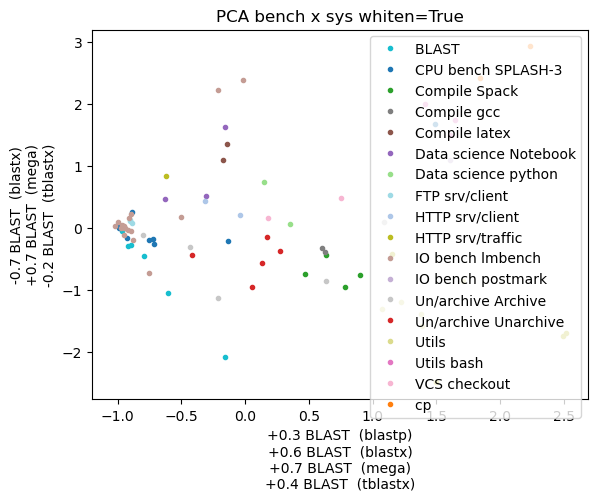

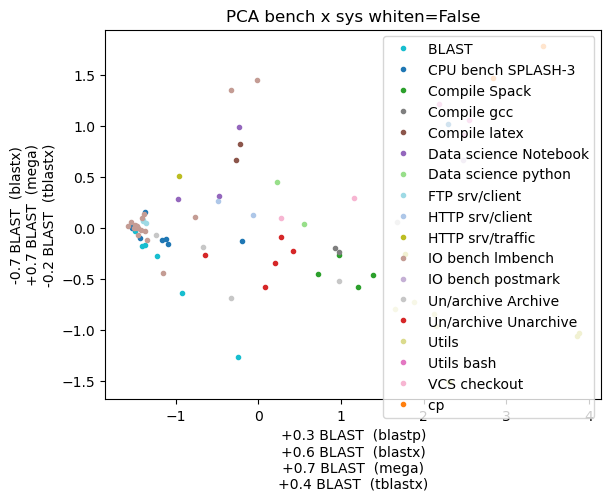

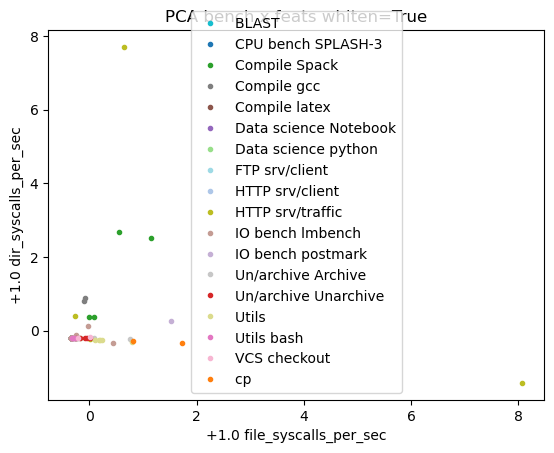

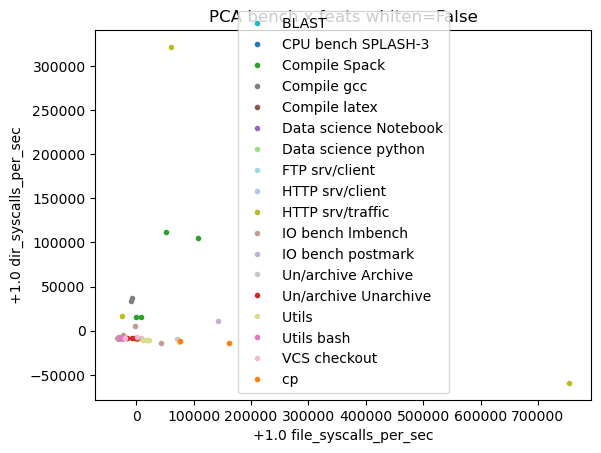

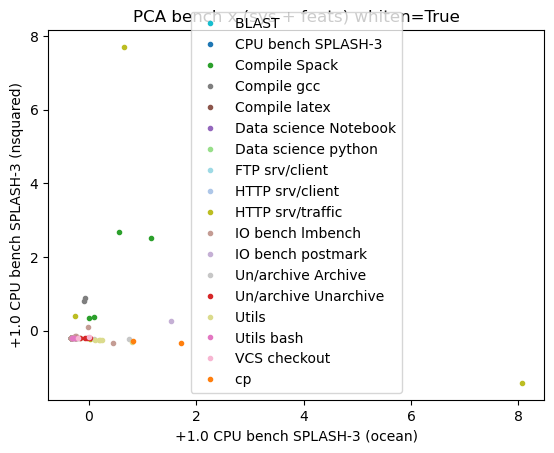

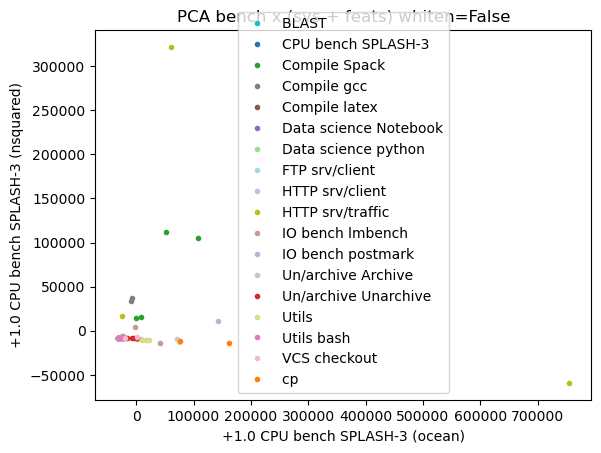

In [473]:
import sklearn.decomposition
import matplotlib.cm
import matplotlib.lines
import matplotlib.pyplot as plt
import itertools

colors = sorted(matplotlib.cm.tab20.colors)

datas = [
    ("bench x sys", systems_by_benchmarks.T, benchmark_names),
    ("bench x feats", benchmarks_by_features, feature_names),
    ("bench x (sys + feats)", numpy.hstack((systems_by_benchmarks.T, benchmarks_by_features)), benchmark_names + feature_names),
]
whitens = [True, False]

for (data_label, data, names), whiten in itertools.product(datas, whitens):
    pca = sklearn.decomposition.PCA(whiten=whiten)
    benchmarks_reduced = pca.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for workload, kind in enumerate(workload_kinds.cat.codes):
        ax.plot(
            benchmarks_reduced[workload, 0],
            benchmarks_reduced[workload, 1],
            linestyle="",
            marker=".",
            color=colors[kind],
        )
    ax.legend(handles=[
        matplotlib.lines.Line2D([0], [0], linestyle="", marker=".", color=colors[cat_code], label=category)
        for cat_code, category in enumerate(workload_kinds.cat.categories)
    ])
    ax.set_title(f"PCA {data_label} whiten={whiten}")
    ax.set_xlabel("\n".join([
        f"{weight:+.1f} {names[feature]}"
        for feature, weight in enumerate(pca.components_[0])
        if numpy.fabs(weight) > 0.2
    ]))
    ax.set_ylabel("\n".join([
        f"{weight:+.1f} {names[feature]}"
        for feature, weight in enumerate(pca.components_[1])
        if numpy.fabs(weight) > 0.2
    ]))
    
    fig.show()

/nix/store/9kgcvj0qdcf01mq20d6ickh63az0bjn2-python3-3.10.13-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


feats for (none) 
feats for CARE -0.18*cputime_per_sec  0.18*dir_syscalls_per_sec  0.09*file_syscalls_per_sec -0.00*fork_syscalls_per_sec -0.08*IPC_syscalls_per_sec
feats for RR -0.43*cputime_per_sec  0.99*socket_syscalls_per_sec  0.03*metadata_syscalls_per_sec  0.35*dir_syscalls_per_sec  0.31*file_syscalls_per_sec -0.44*IPC_syscalls_per_sec
feats for ReproZip -0.78*cputime_per_sec  0.46*socket_syscalls_per_sec -0.18*metadata_syscalls_per_sec  0.04*file_syscalls_per_sec -0.56*fork_syscalls_per_sec -0.61*IPC_syscalls_per_sec  2.25*constant_frac
feats for fsatrace  0.03*metadata_syscalls_per_sec  0.01*dir_syscalls_per_sec
feats for strace -0.25*cputime_per_sec  0.48*socket_syscalls_per_sec  0.16*dir_syscalls_per_sec  0.11*file_syscalls_per_sec -0.07*exits_syscalls_per_sec -0.25*IPC_syscalls_per_sec


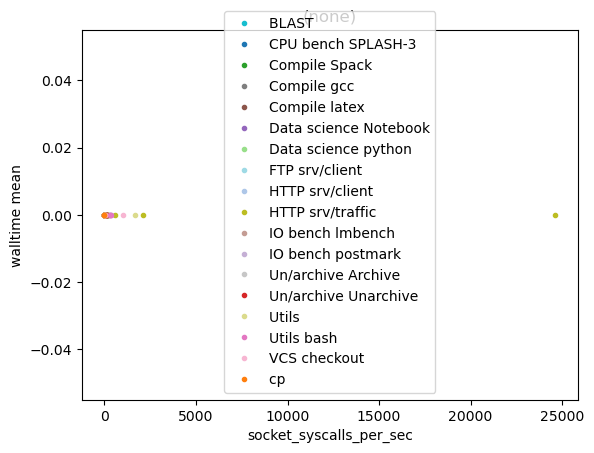

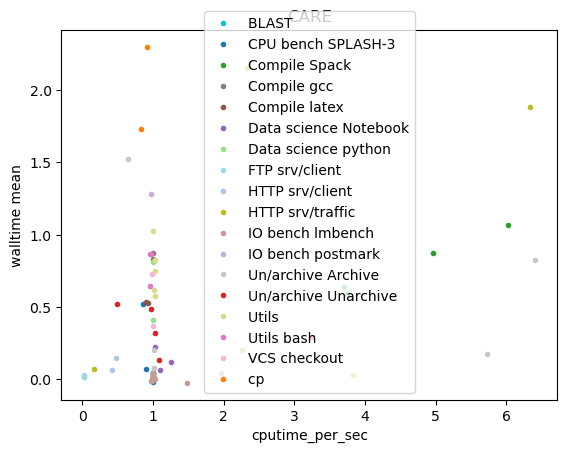

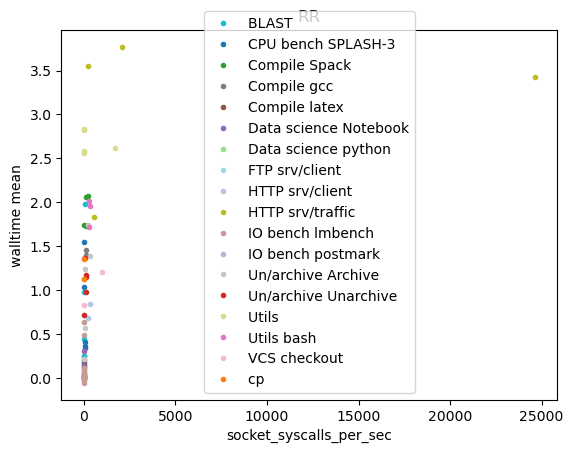

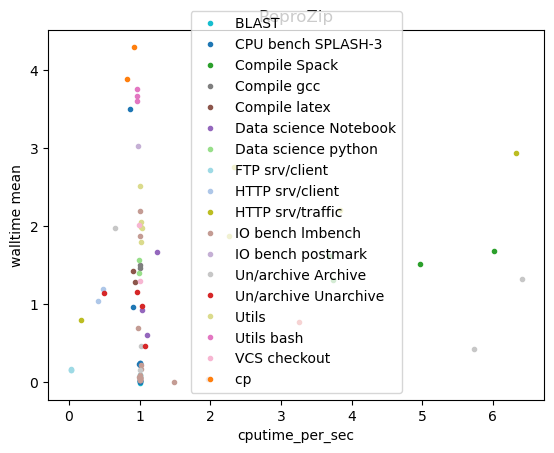

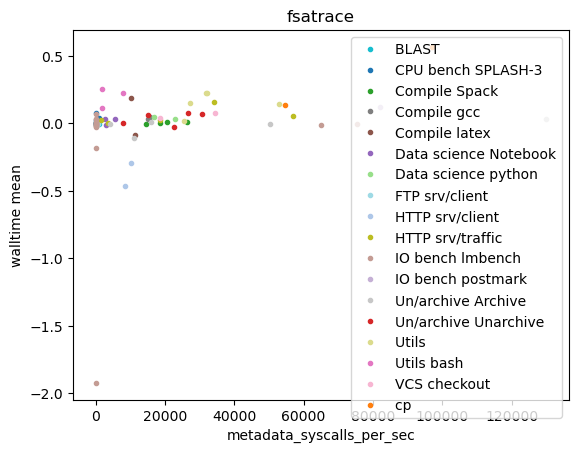

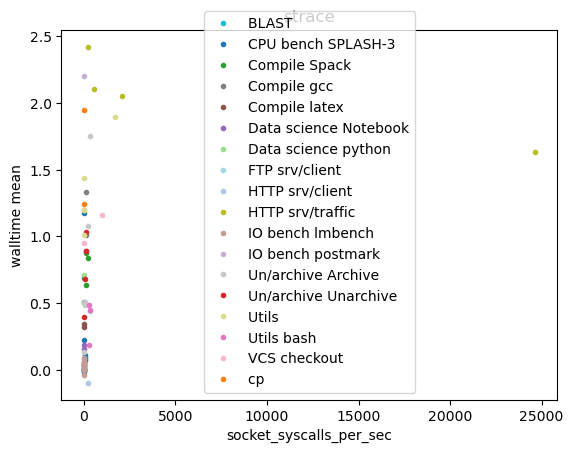

In [436]:
for collector in agged.index.levels[0]:
    reg = sklearn.linear_model.Lasso(alpha=0.01)
    data = features_df.loc[:, :].values
    data = (data - data.mean(axis=1)[:, numpy.newaxis]) / data.std(axis=1)[:, numpy.newaxis]
    reg.fit(
        data,
        log_rel_slowdown.loc[collector, :].values,
    )

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(collector)
    ax.set_ylabel("walltime mean")
    print(f"feats for {collector}", " ".join(
        f"{weight: .2f}*{feature}"
        for feature, weight in zip(list(features_df.columns) + ["one"], reg.coef_)
        if numpy.fabs(weight) > 0.0001
    ))
    feature = max(zip(numpy.fabs(reg.coef_)[:-1], features_df.columns))[1]
    ax.set_xlabel(feature)
    for workload in agged.index.levels[1]:
        x = features_df.loc[workload, feature]
        y = agged.loc[collector, workload]["log_rel_slowdown"] - agged.loc["(none)", workload]["log_rel_slowdown"]
        color = colors[agged["workload_kind"].cat.codes.loc[collector, workload]]
        ax.plot(
            x,
            y,
            linestyle="",
            marker=".",
            color=color,
        )
        # ax.annotate(
        #     workload[:8],
        #     xy=(x, y),
        #     xytext=(0, -4),
        #     color=color,
        #     textcoords='offset points',
        #     size=8,
        #     ha='center', va='bottom',
        # )
    ax.legend(handles=[
        matplotlib.lines.Line2D([0], [0], linestyle="", marker=".", color=colors[cat_code], label=category)
        for cat_code, category in enumerate(workload_kinds.cat.categories)
    ])
    fig.show()

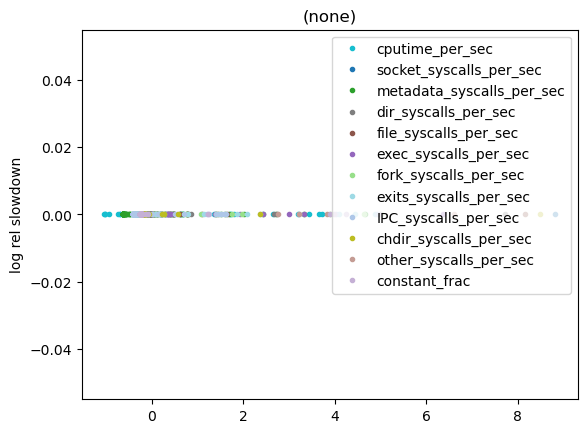

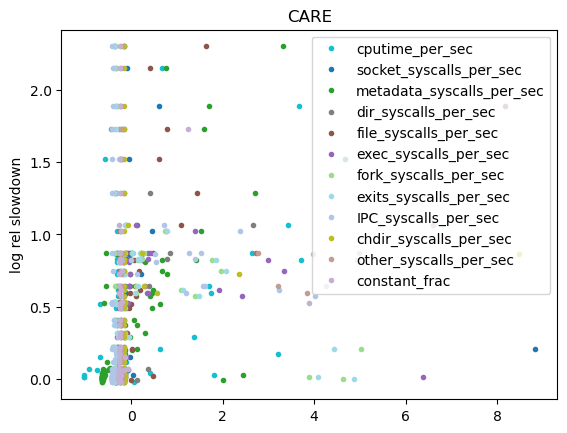

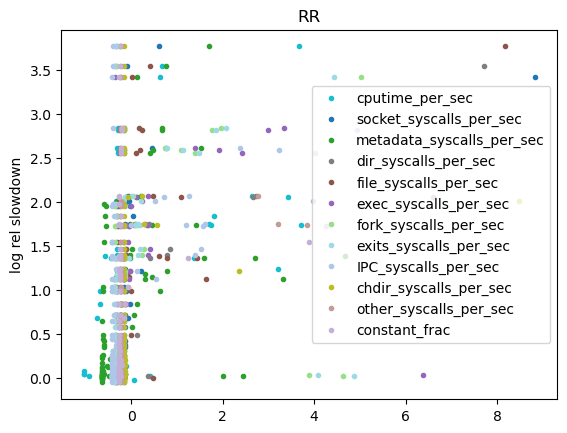

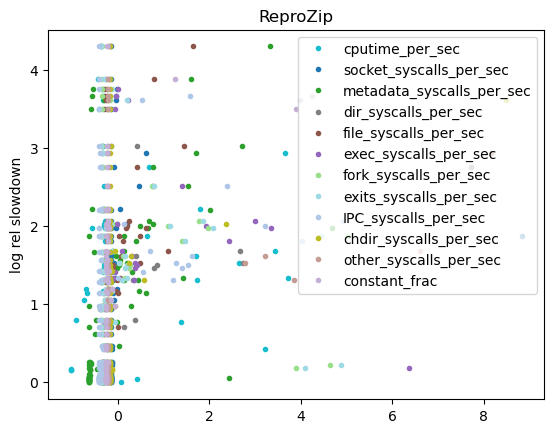

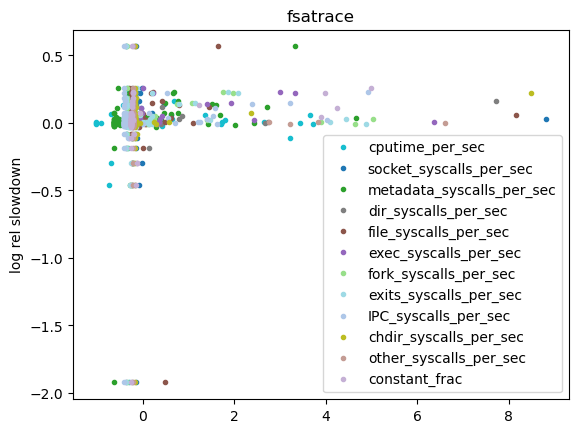

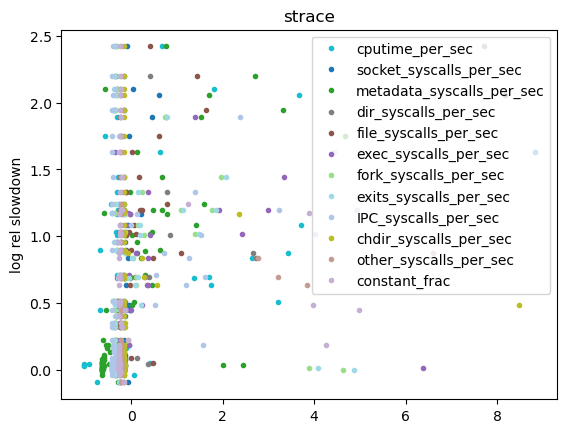

In [437]:
for collector in agged.index.levels[0]:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(collector)
    ax.set_ylabel("log rel slowdown")
    for color, feature in zip(colors, feature_names):
        mean = features_df.loc[:, feature].mean()
        std = features_df.loc[:, feature].std()
        ax.plot(
            (features_df.loc[:, feature] - mean) / std,
            agged.loc[collector, :]["log_rel_slowdown"],
            linestyle="",
            marker=".",
            color=color,
        )
    ax.legend(handles=[
        matplotlib.lines.Line2D([0], [0], linestyle="", marker=".", color=color, label=feature)
        for color, feature in zip(colors, feature_names)
    ])
    fig.show()

# Let's play the _corrected_ benchmark minimization game

In [536]:
mean_absolute_error = lambda a, b: numpy.mean(numpy.fabs(a - b))

root_mean_squared_error = lambda a, b: numpy.sqrt(numpy.mean((a-b)**2))

In [537]:
class BenchmarkMinimizer:
    @abc.abstractmethod
    def select_benchmarks(
        self,
        benchmarks_by_features: numpy.typing.NDArray
    ) -> tuple[list[int], numpy.float64]:
        """
        benchmarks_by_features: array where the (j,m)th element is the mth feature of the jth benchmark

        returns a tuple containing:
          - the log-liklihood
        
        Liklihood is the probability of observing this data given the parameters you inferred
        Used to compute the Akaike Information Criterion.
        Return numpy.NaN if you just don't care.
        """

In [538]:
class DimReducerAndClusterer(BenchmarkMinimizer):
    def __init__(
        self,
        dim_reducer: sklearn.base.BaseEstimator,
        clusterer: sklearn.base.BaseEstimator,
    ) -> None:
        self.dim_reducer = dim_reducer
        self.clusterer = clusterer
        self.name = str
        self.n_benchmarks = n_benchmarks

    def select_benchmarks(
        self,
        benchmarks_by_features: numpy.typing.NDArray
    ) -> tuple[list[int], numpy.float64]:
        benchmarks_by_features = self.dim_reducer.fit_transform(benchmarks_by_features)
        self.clusterer.fit_predict(benchmarks_by_features)
        self.unselected_benchmarks = set(range(benchmarks_by_features.shape[0]))
        self.selected_benchmarks = list[int]()

        if hasattr(self.clusterer, "labels_"):
            self.cluster_labels = getattr(self.clusterer, "labels_", None)
            n_labels = len(set(self.cluster_labels))
            for label in self.cluster_labels:
                assert isinstance(label, (int, numpy.int32, numpy.int64)) and 0 <= label < n_labels, (label, type(label))
        else:
            raise NotImplementedError(f"Not implemtned for {self.clusterer.__class__.__name__}")
        
        if hasattr(self.clusterer, "cluster_centers_"):
            self.cluster_centers = self.clusterer.cluster_centers_
        elif hasattr(self.clusterer, "means_"):
            self.cluster_centers = self.clusterer.means_
        else:
            n_labels = len(set(self.cluster_labels))
            label2members = [
                [] for _ in range(n_labels)
            ]
            for member, label in zip(benchmarks_by_features, self.cluster_labels):
                label2members[label].append(member)
            self.cluster_centers = [
                numpy.mean(numpy.array(members), axis=0)
                for members in label2members
            ]
        for cluster in self.cluster_centers:
            selected_benchmark = min(
                self.unselected_benchmarks,
                key=lambda benchmark: scipy.spatial.distance.euclidean(
                    benchmarks_by_features[benchmark, :],
                    cluster,
                ),
            )
            self.selected_benchmarks.append(selected_benchmark)
            self.unselected_benchmarks.remove(selected_benchmark)
        return (self.selected_benchmarks, numpy.NaN)

    def shortname(self) -> str:
        dim_reducer = {"NoReduction": "", "PCA": f"PCA-{getattr(self.dim_reducer, 'n_components', None)} "}[self.dim_reducer.__class__.__name__]
        clusterer = {"AgglomerativeClustering": "agglom", "KMeans": "k-means"}[self.clusterer.__class__.__name__]
        return dim_reducer + clusterer

In [539]:
class NoReduction(sklearn.base.BaseEstimator):
    def fit_transform(self, X: numpy.typing.NDArray, y: None = None) -> numpy.typing.NDArray:
        return X

In [540]:
import sklearn.decomposition
import sklearn.manifold
import sklearn.mixture

random_state = 0
benchmark_subsetters = [
    DimReducerAndClusterer(dim_reducer, clusterer)
    for dim_reducer in [
        NoReduction(),
        *itertools.chain.from_iterable(
            [
                sklearn.decomposition.PCA(n_components=n_components, random_state=random_state),
                #sklearn.manifold.Isomap(n_components=n_components),
                #sklearn.manifold.LocallyLinearEmbedding(n_components=n_components, random_state=random_state),
                #sklearn.manifold.TSNE(n_components=n_components, random_state=random_state),
            ]
            for n_components in [2, 4]
        ),
    ]
    for clusterer in [
        *itertools.chain.from_iterable(
            [
                sklearn.cluster.KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', random_state=random_state),
                sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage="ward"),
                #sklearn.mixture.GaussianMixture(n_components=n_clusters, random_state=random_state),
            ]
            for n_clusters in range(1, 50)
        )
    ]
]

In [541]:
import tqdm

In [542]:
import sklearn.preprocessing
import scipy.spatial
standardizer = sklearn.preprocessing.StandardScaler()
benchmarks_by_all_features = numpy.hstack([
    standardizer.fit_transform(numpy.hstack([
        systems_by_benchmarks.T,
        benchmarks_by_features,
    ])),
    numpy.ones((n_benchmarks, 1))
])
mean_features = benchmarks_by_all_features.mean(axis=0)
for benchmark_subsetter in tqdm.tqdm(benchmark_subsetters):
    selected_benchmarks = benchmark_subsetter.select_benchmarks(benchmarks_by_all_features)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:02<00:00, 131.28it/s]


In [543]:
subsetter_df = pandas.DataFrame.from_records(
    [
        {
            "rmse-dist": root_mean_squared_error(scipy.spatial.distance_matrix(
                benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks],
                benchmarks_by_all_features,
            ).min(axis=0), 0),
            "rmse-accuracy": root_mean_squared_error(
                (
                    sklearn.linear_model.LinearRegression(positive=True, fit_intercept=False)
                    .fit(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T, mean_features)
                    .predict(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T)
                ),
                mean_features,
            ),
            "r-accuracy": (
                sklearn.linear_model.LinearRegression(positive=True, fit_intercept=False)
                .fit(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T, mean_features)
                .score(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T, mean_features)
            ),
            "name": benchmark_subsetter.shortname(),
            "k": len(benchmark_subsetter.selected_benchmarks),
        }
        for benchmark_subsetter in benchmark_subsetters
    ],
).sort_values(["name", "k"]).set_index(["name", "k"])
subsetter_df

rmse-dist  rmse-accuracy  r-accuracy
name         k                                       
PCA-2 agglom 1    4.446408   1.966544e-01    0.224392
             2    4.110559   1.821286e-01    0.334741
             3    3.783232   1.691411e-01    0.426237
             4    3.540546   1.188923e-01    0.716507
             5    3.468063   1.149996e-01    0.734767
...                    ...            ...         ...
k-means      45   0.284258   9.830388e-17    1.000000
             46   0.261707   9.830388e-17    1.000000
             47   0.245454   9.830388e-17    1.000000
             48   0.223282   9.830388e-17    1.000000
             49   0.202151   1.293353e-16    1.000000

[294 rows x 3 columns]

Change `opt_x` in the following cell to change where the dotted line pointer falls.

opt_x = 14

opt_y=1.5


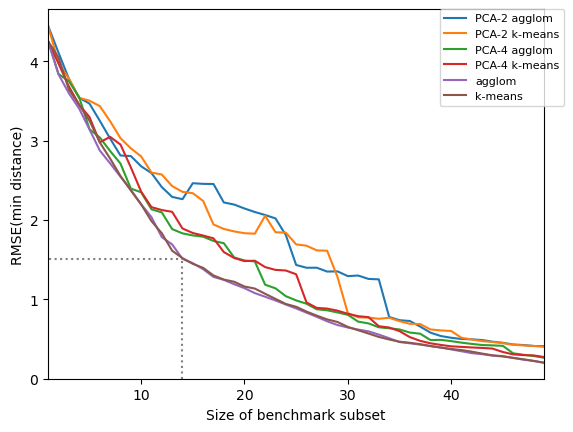

In [544]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
for i, predictor in enumerate(subsetter_df.index.levels[0]):
    ks = subsetter_df.loc[predictor, :].index
    rmse_dist = subsetter_df.loc[predictor, :]["rmse-dist"]
    rmse_accuracy = subsetter_df.loc[predictor, :]["r-accuracy"]
    ax.plot(ks, rmse_dist, color=matplotlib.cm.tab10.colors[i], label=predictor)
xmax = subsetter_df.index.levels[1].max()
ax.set_xlim(1, xmax)
ax.set_ylim(0, None)
opt_y = subsetter_df.loc["agglom", opt_x]["rmse-dist"]
print(f"{opt_y=:.1f}")
ax.plot([opt_x, opt_x], [0, opt_y], color="gray", linestyle=":")
ax.plot([0, opt_x], [opt_y, opt_y], color="gray", linestyle=":")
ax.set_xlabel("Size of benchmark subset")
ax.set_ylabel("RMSE(min distance)")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, prop={"size": 8})
fig.savefig(output_dir / "subsetting-dist.pdf", bbox_inches="tight")

opt_y=0.023, numpy.exp(opt_y)=1.024, numpy.exp(2*opt_y)=1.048
Linear model gets within 2% 65% of the time and 5% 95% of the time


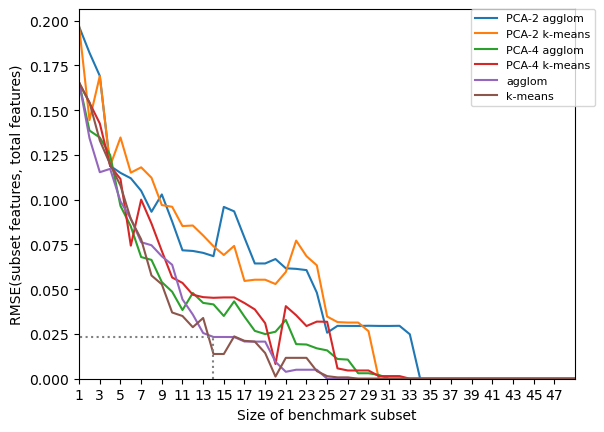

In [545]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
for i, predictor in enumerate(subsetter_df.index.levels[0]):
    ks = subsetter_df.loc[predictor, :].index
    rmse_dist = subsetter_df.loc[predictor, :]["rmse-dist"]
    rmse_accuracy = subsetter_df.loc[predictor, :]["rmse-accuracy"]
    ax.plot(ks, rmse_accuracy, color=matplotlib.cm.tab10.colors[i], label=predictor)
xmax = subsetter_df.index.levels[1].max()
ax.set_xticks(range(1, xmax, 2))
ax.set_xlim(1, xmax)
ax.set_ylim(0, None)
opt_y = subsetter_df.loc["agglom", opt_x]["rmse-accuracy"]
print(f"{opt_y=:.3f}, {numpy.exp(opt_y)=:.3f}, {numpy.exp(2*opt_y)=:.3f}")
ax.plot([opt_x, opt_x], [0, opt_y], color="gray", linestyle=":")
print(f"Linear model gets within {100 * (numpy.exp(opt_y) - 1):.0f}% 65% of the time and {100 * (numpy.exp(opt_y*2) - 1):.0f}% 95% of the time")
ax.plot([0, opt_x], [opt_y, opt_y], color="gray", linestyle=":")
ax.set_xlabel("Size of benchmark subset")
ax.set_ylabel("RMSE(subset features, total features)")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, prop={"size": 8})
fig.savefig(output_dir / "subsetting-accuracy.pdf", bbox_inches="tight")

In [546]:
benchmark_subsetter = DimReducerAndClusterer(
    NoReduction(),
    sklearn.cluster.AgglomerativeClustering(n_clusters=opt_x, linkage="ward", compute_distances=True),
)
selected_benchmarks, _ = benchmark_subsetter.select_benchmarks(benchmarks_by_all_features)

In [547]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    return linkage_matrix, scipy.cluster.hierarchy.dendrogram(linkage_matrix, **kwargs)

In [548]:
label2members = [[] for _ in range(benchmark_subsetter.n_benchmarks)]
for member, label in enumerate(benchmark_subsetter.cluster_labels):
    label2members[label].append(member)
linreg = sklearn.linear_model.LinearRegression(positive=True)
linreg.fit(benchmarks_by_all_features[benchmark_subsetter.selected_benchmarks].T, mean_features)
for label, (center, members, weight) in enumerate(zip(benchmark_subsetter.selected_benchmarks, label2members, linreg.coef_)):
    assert center in members
    members = [member for member in members if member != center]
    center_name = benchmark_names[center]
    member_names = ", ".join([benchmark_names[member] for member in members])
    print(f"{center_name:30s} & {weight*100: .1f} & {member_names} \\\\".replace(" ()", "   "))
print("\\midrule")
print(f"all                            & {linreg.coef_.sum()*100:.1f} & \\\\")

Un/archive Unarchive (pigz)    &  0.0 & Compile gcc (hello-world), Compile gcc (threads), Data science python (python-hello-world), IO bench lmbench (fstat), IO bench lmbench (stat), Un/archive Unarchive (gzip), Un/archive Unarchive (unarchive), VCS checkout  (git git-repo-1), VCS checkout  (hg hg-repo-1) \\
Compile Spack (perl)           &  5.7 & Compile Spack (git), Compile Spack (hdf5~mpi), Compile Spack (python) \\
Utils  (hello)                 &  8.0 & Utils  (echo), Utils  (ls), Utils  (ps), Utils  (true) \\
IO bench postmark (main)       &  8.8 & Un/archive Archive (archive), cp  (linux), cp  (smaller) \\
Un/archive Archive (bzip2)     &  55.0 & BLAST  (blastn), BLAST  (blastp), BLAST  (blastx), BLAST  (mega), BLAST  (tblastn), BLAST  (tblastx), CPU bench SPLASH-3 (cholesky), CPU bench SPLASH-3 (lu), CPU bench SPLASH-3 (nsquared), CPU bench SPLASH-3 (ocean), CPU bench SPLASH-3 (radiosity), CPU bench SPLASH-3 (radix), CPU bench SPLASH-3 (raytrace), CPU bench SPLASH-3 (spatial), 

In [559]:
linkage, R = plot_dendrogram(
    benchmark_subsetter.clusterer,
    ax=ax,
    truncate_mode="lastp",
    p=20,
    no_plot=True,
)

In [560]:
def leaf_label_func(id: int, count: int = 1) -> str:
    if 0 <= id < n_benchmarks:
        if count == 1:
            #assert id in benchmark_subsetter.selected_benchmarks
            return benchmark_names[id]
        else:
            label = benchmark_subsetter.cluster_labels[id]
            center = benchmark_names[label]
            members = ", ".join(benchmark_names[b] for b in label2members[label][:4])
            return f"{center}: {count}"
            #+ ": " + members + ("..." if len(label2members[label]) > 4 else "")
    elif n_benchmarks <= id < n_benchmarks * 2:
        count = int(linkage[id - n_benchmarks][3])
        left_child = int(linkage[id - n_benchmarks][0])
        return leaf_label_func(left_child, count)
    else:
        raise ValueError()

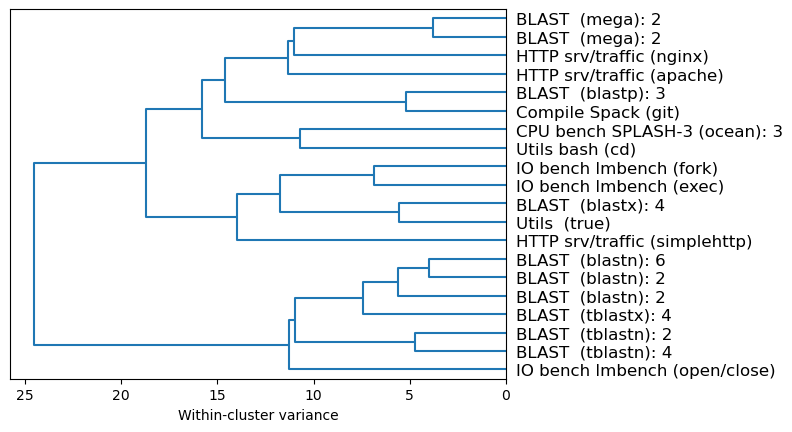

In [561]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
linkage, R = plot_dendrogram(
    benchmark_subsetter.clusterer,
    ax=ax,
    leaf_label_func=leaf_label_func,
    # labels=[
    #     benchmark_names[benchmark]
    #     for benchmark in benchmark_subsetter.selected_benchmarks
    # ],
    truncate_mode="lastp",
    p=20,
    labels=benchmark_names,
    #leaf_rotation=90,
    color_threshold=0,
    orientation="left",
)
ax.set_xlabel("Within-cluster variance")
fig.savefig(output_dir / "dendrogram.pdf", bbox_inches="tight")
None

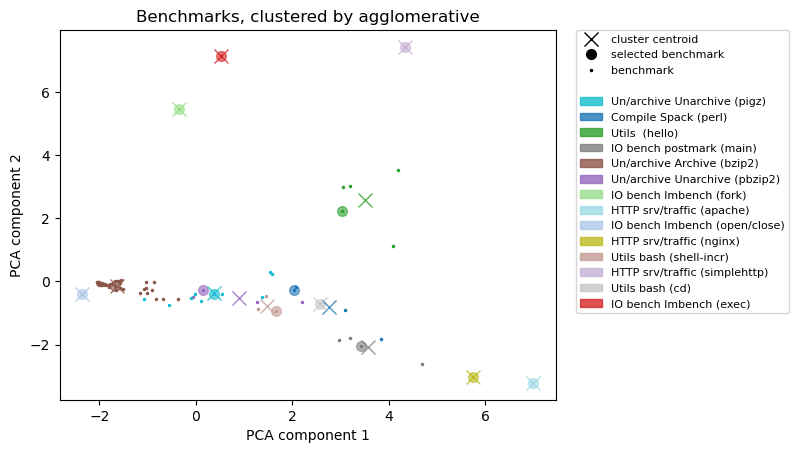

In [563]:
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"Benchmarks, clustered by agglomerative")
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
pca = sklearn.decomposition.PCA(n_components=2).fit(benchmarks_by_all_features)
for i in range(len(benchmarks_by_all_features)):
    ax.plot(
        pca.transform(benchmarks_by_all_features)[i, 0],
        pca.transform(benchmarks_by_all_features)[i, 1],
        color=colors[benchmark_subsetter.clusterer.labels_[i]],
        marker=".",
        markersize=3,
    )
for cluster_label, i in enumerate(selected_benchmarks):
    ax.plot(
        pca.transform(benchmarks_by_all_features)[i, 0],
        pca.transform(benchmarks_by_all_features)[i, 1],
        color=(*colors[cluster_label][:3], 0.6),
        marker="o",
        markersize=7,
        markeredgewidth=1,
    )
for cluster_label, cluster_center in enumerate(benchmark_subsetter.cluster_centers):
    ax.plot(
        pca.transform(cluster_center[numpy.newaxis, :])[0, 0],
        pca.transform(cluster_center[numpy.newaxis, :])[0, 1],
        color=(*colors[cluster_label][:3], 0.8),
        marker="x",
        markersize=10,
        markeredgewidth=1,
    )
ax.legend(
    handles=[
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker="x", markersize=10, markeredgewidth=1, label="cluster centroid"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker="o", markersize=7, markeredgewidth=1, label="selected benchmark"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker=".", markersize=3, label="benchmark"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker="", label=""),
        *[
            matplotlib.patches.Patch(color=(*colors[cluster_label], 0.8), label=benchmark_names[i])
            for cluster_label, i in enumerate(selected_benchmarks)
        ],
    ],
    prop={"size": 8},
    bbox_to_anchor=(1.04, 1.0),
    borderaxespad=0,
)
fig.savefig(output_dir / "pca0.pdf", bbox_inches="tight")
xlims = ax.get_xlim()
ylims = ax.get_ylim()

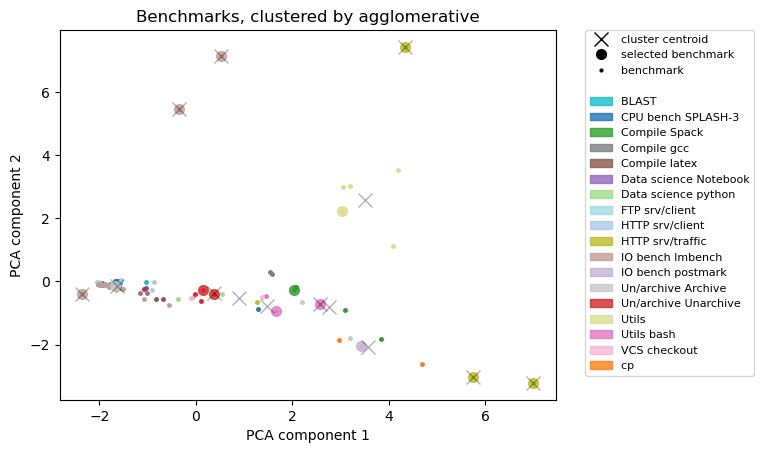

In [564]:
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"Benchmarks, clustered by agglomerative")
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
for i in range(len(benchmarks_by_all_features)):
    ax.plot(
        pca.transform(benchmarks_by_all_features)[i, 0],
        pca.transform(benchmarks_by_all_features)[i, 1],
        color=colors[workload_kinds.cat.codes[benchmark_names[i]]],
        marker=".",
        markersize=5,
    )
for i in selected_benchmarks:
    ax.plot(
        pca.transform(benchmarks_by_all_features)[i, 0],
        pca.transform(benchmarks_by_all_features)[i, 1],
        color=(*colors[workload_kinds.cat.codes[benchmark_names[i]]], 0.8),
        marker="o",
        markersize=7,
        markeredgewidth=1,
    )
for cluster_label, cluster_center in enumerate(benchmark_subsetter.cluster_centers):
    ax.plot(
        pca.transform(cluster_center[numpy.newaxis, :])[0, 0],
        pca.transform(cluster_center[numpy.newaxis, :])[0, 1],
        color=(0, 0, 0, 0.3),
        marker="x",
        markersize=10,
        markeredgewidth=1,
    )
import scipy.spatial
#vor = scipy.spatial.Voronoi(predictor.kmeans.cluster_centers_[:, :2])
#scipy.spatial.voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.legend(
    handles=[
        matplotlib.lines.Line2D([0], [0], linestyle="", marker="x", markersize=10, color="black", label="cluster centroid"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker="o", markersize=7, markeredgewidth=1, label="selected benchmark"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker=".", markersize=4, label="benchmark"),
        matplotlib.lines.Line2D([0], [0], linestyle="", marker="", label=""),
        *[
            matplotlib.patches.Patch(color=(*color, 0.8), label=workload_kind)
            #matplotlib.lines.Line2D([0], [0], linestyle="", marker=".", markersize=7, color=color, label=workload_kind)
            for color, workload_kind in zip(colors, workload_kinds.cat.categories)
        ],
    ],
    bbox_to_anchor=(1.4, 1.0),
    borderaxespad=0,
    prop={"size": 8},
)
fig.savefig(output_dir / "pca1.pdf", bbox_inches="tight")

# Let's play the new system game

It is more of a dialogue.

- **Given** integer N, workloads x benchmarks, and benchmarks x features matrix
- **Select** select N workloads and other parameters
- **Given** new system's log slowdown ratio on N selected workloads. This represents a hypothetical read of my publication who wants to test there system, but doesn't have the time to run all ~100s of benchmarks.
- **Predict** predict new system's log slowdown ratio on all other workloads

I initially scored this game by cross-validated root-mean-squared-error. However, I've found that even with cross-validation, more complex models are not "punished" enough. So I decided to also include Akaike Information Criterion (modified for small sample size). But in order to compute the AIC, one has to know the likelihood function. If you're lazy, your model has uninformitave priors, and your errors are normally distributed (although with unknown variance), you can use `naive_log_likelihood`, which computes the likelihood-maximizing variance, and returns the likelihood of the data based on that.

In [498]:
class NewSystemPredictor:
    @abc.abstractmethod
    def select_benchmarks(
        self,
        k: int,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        """
        k: number of benchmarks to select
        systems_by_benchmarks: array where the (i,j)th element is the log of the ith system's slowdown on the jth benchmark
        benchmarks_by_features: array where the (j,m)th element is the mth feature of the jth benchmark

        returns a tuple containing:
          - k benchmarks to select
          - the log-liklihood
        
        Liklihood is the probability of observing this data given the parameters you inferred
        Used to compute the Akaike Information Criterion.
        Return numpy.NaN if you just don't care.
        """

    @abc.abstractmethod
    def predict_new_system(
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        """
        new_system_by_selected_benchmarks: array where the (g,p)th element is the log of the gth new system's slowdown on the pth *selected* benchmark

        returns an array where the (g,q)th element is the log of the gth new system's slowdown on the qth *unselected* benchmark
        """

    @abc.abstractmethod
    def n_parameters(self) -> int:
        """
        Returns the number of parameters used to make this estimation.
        Used to calculate the Akaike Information Criterion.
        """

Assume a model predicts $\hat{r}_i = f(r_i) + \eta_i$ where $\eta_i$ is normally distributed around 0 with unknown variance.

Let's find the variance which maximizes likelihood.

First, I'll write down the PDF (which is likelihood function) for the Normal distribution, where $\mu$ is the prediction and $x$ is the observation:

$$ f(x | \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left(-\frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2 \right) $$

Then log both sides.

$$\log f(x | \mu, \sigma) = -\log(\sigma \sqrt{2\pi}) - \frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2 $$

In order to maximize, take a derivative with $\sigma$.

$$\frac{d}{d\sigma} \log f(x | \mu, \sigma) = -\frac{1}{\sigma} + \frac{(x - \mu)^2}{\sigma^3} $$

Set that to zero.

$$0 = \frac{d}{d\sigma} \log f(x | \mu, \sigma) \implies \frac{1}{\sigma} = \frac{(x - \mu)^2}{\sigma^3} \implies \sigma = |x - \mu|$$

Therefore $\log f(x | \mu, \sigma)$ has a maximum at $\sigma = |x - \mu|$.

We can plug that back in to the log-likelihood function.

In [499]:
def naive_log_likelihood(actual, predicted) -> float:
    std = numpy.clip(numpy.mean(numpy.fabs(actual - predicted)), 1e-2, None)
    # Some of the values we hit "dead-on"
    # This predicts the sigma should be 0, which is wrong
    # It should actually be a small positive number.
    
    # Plugging this in to the log PDF above
    return numpy.sum(-1/2*((actual - predicted)/std)**2 - numpy.log(std) + 1/2*numpy.log(2*numpy.pi))

In [500]:
import scipy.linalg.interpolative

class InitialSystemPredictor(NewSystemPredictor):
    """
    This is a simple predictor just to test the mechanics.

    It simply selects self.benchmarks.
    Then it runs a regression to all the unselected benchmarks based on the selected benchmarks.
    That's it.

    Note this method will overesimate the "goodness" in cross-validation,
    if feature-selection (input to __init__) is determined by the whole dataset, not just the train dataset.
    """
    def __init__(self, benchmarks: list[int]) -> None:
        self.benchmarks = benchmarks
        self.n_benchmarks = len(benchmarks)

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        unselected_benchmarks = [
            benchmark
            for benchmark in range(systems_by_benchmarks.shape[1])
            if benchmark not in self.benchmarks
        ]
        self.coeffs = numpy.linalg.pinv(systems_by_benchmarks[:, self.benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            systems_by_benchmarks[:, self.benchmarks] @ self.coeffs,
        )
        # the selected benchmarks will get probability = 1, log likelihood = 0, so you can imagine I wrote ... + 0 + 0 + 0 to the end
        return self.benchmarks, log_likelihood

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.coeffs

    def n_parameters(self) -> int:
        # add one for the stddev of errors computed by naive_log_likelhiood
        return len(self.coeffs.flatten()) + 1

    def __str__(self) -> str:
        return f"Initial guess {self.benchmarks!r}"

In [501]:
import scipy.linalg.interpolative

class InterpDecomp(NewSystemPredictor):
    """
    This method uses Interpolative Decomposition (ID).

    ID factors a matrix A into B @ C.
    It selects k columns of A, and puts those in B.
    It puts the identity matrix in the corresponding columns of C.
    The remaining N - k columns of A are predicted from a linear regression on the k columns of A (equivalently, all the columns of B).

    This method should be pretty good.
    """
    def __init__(self, n_benchmarks: int, use_features: int, whiten: bool) -> None:
        self.n_benchmarks = n_benchmarks
        self.use_features = use_features
        self.whiten = whiten

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        if self.use_features == 0:
            data = numpy.vstack([
                systems_by_benchmarks,
                benchmarks_by_features.T,
            ])
        elif self.use_features == 1:
            data = systems_by_benchmarks
        elif self.use_features == -1:
            data = benchmarks_by_features.T
        else:
            raise NotImplementedError(self.use_features)
        if self.n_benchmarks > len(data):
            raise RuntimeErorr(f"Can't select more benchmarks ({self.n_benchmarks}) than there are input dimensions ({len(data)})")
        if self.whiten:
            data = (data - data.mean(axis=1)[:, numpy.newaxis]) / numpy.clip(data.std(axis=1, ddof=1)[:, numpy.newaxis], 0.01, None)
        self.idx, self.proj = scipy.linalg.interpolative.interp_decomp(data, self.n_benchmarks, rand=False)
        # skel = scipy.linalg.interpolative.reconstruct_skel_matrix(data, self.k, idx)
        # data_est = scipy.linalg.interpolative.reconstruct_matrix_from_id(skel, idx, proj)[:len(systems_by_benchmarks), :]
        selected_benchmarks = self.idx[:self.n_benchmarks]
        unselected_benchmarks = self.idx[self.n_benchmarks:]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            self.predict_new_systems(systems_by_benchmarks[:, selected_benchmarks]),
        )
        return selected_benchmarks, log_likelihood

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        predicted_unselected_benchmark_runtime = new_systems_by_selected_benchmarks @ self.proj
        return predicted_unselected_benchmark_runtime

    def n_parameters(self) -> int:
        # add one for the stddev of errors computed by naive_log_likelhiood
        return len(self.proj.flatten()) + 1

    def __str__(self) -> str:
        features = {
            -1: "others",
            0: "perf+others",
            1: "perf",
        }[self.use_features]
        whiten = "stand." if self.whiten else ""
        return f"ID {features} {whiten}"

In [502]:
import sklearn.decomposition
import sklearn.cluster

class PCAKmeans(NewSystemPredictor):
    def __init__(self, n_benchmarks: int, use_features: int, whiten: bool) -> None:
        self.n_benchmarks = n_benchmarks
        self.use_features = use_features
        self.whiten = whiten

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        if self.use_features == 0:
            data = numpy.vstack([
                systems_by_benchmarks,
                benchmarks_by_features.T,
            ])
        elif self.use_features == 1:
            data = systems_by_benchmarks
        elif self.use_features == -1:
            data = benchmarks_by_features.T
        else:
            raise NotImplementedError(self.use_features)
        self.pca = sklearn.decomposition.PCA(
            whiten=self.whiten,
            random_state=0,
        )
        self.rotated_data = self.pca.fit_transform(data.T)
        self.kmeans = sklearn.cluster.KMeans(n_clusters=self.n_benchmarks, random_state=0, init="k-means++", n_init=2, max_iter=1000)
        self.labels = self.kmeans.fit_predict(self.rotated_data)
        self.benchmarks = [
            min(
                range(benchmarks_by_features.shape[0]),
                key=lambda benchmark: scipy.spatial.distance.euclidean(self.rotated_data[benchmark], cluster_center),
            )
            for cluster_center in self.kmeans.cluster_centers_
        ]
        assert len(set(self.benchmarks)) == self.n_benchmarks, (
            "Somehow, we chose fewer benchmarks than expected;"
            "this can happen if one benchmark is the closest to two different cluster centrs"
        )
        unselected_benchmarks = [
            benchmark
            for benchmark in range(systems_by_benchmarks.shape[1])
            if benchmark not in self.benchmarks
        ]
        self.coeffs = numpy.linalg.pinv(systems_by_benchmarks[:, self.benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            systems_by_benchmarks[:, self.benchmarks] @ self.coeffs,
        )
        # the selected benchmarks will get probability = 1, log likelihood = 0, so you can imagine I wrote ... + 0 + 0 + 0 to the end
        return self.benchmarks, log_likelihood

    def plot(self, ax: "maptloltib.axes.Axes") -> None:
        for i in range(len(self.rotated_data)):
            ax.plot(
                self.rotated_data[i, 0],
                self.rotated_data[i, 1], 
                color=colors[self.kmeans.labels_[i]],
                marker=".",
                markersize=2,
            )
        for cluster_label, benchmark in enumerate(self.benchmarks):
            ax.plot(
                self.rotated_data[benchmark, 0],
                self.rotated_data[benchmark, 1],
                color=(*colors[cluster_label][:3], 0.6),
                marker="o",
                markersize=3,
                markeredgewidth=1,
            )
        for cluster_label, cluster_center in enumerate(self.kmeans.cluster_centers_):
            ax.plot(
                cluster_center[0],
                cluster_center[1], 
                color=(*colors[cluster_label][:3], 0.6),
                marker="x",
                markersize=15,
                markeredgewidth=1,
            )
        ax.legend(handles=[
            matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 0.6), linestyle="", marker="x", markersize=15, markeredgewidth=1, label="cluster center"),
            matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 0.6), linestyle="", marker="o", markersize=3, markeredgewidth=1, label="chosen benchmark"),
            matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker=".", markersize=2, label="benchmark"),
        ])

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.coeffs

    def n_parameters(self) -> int:
        # add one for the stddev of errors computed by naive_log_likelhiood
        return len(self.coeffs.flatten()) + 1

    def __str__(self) -> str:
        features = {
            -1: "other",
            0: "perf+other",
            1: "perf",
        }[self.use_features]
        whiten = "stand." if self.whiten else ""
        return f"PCA-kmeans {features} {whiten}"

In [503]:
class BestFeaturePredictor(NewSystemPredictor):
    """
    First, find the best features to use to predict benchmarks.
    Second, find the tests which best optimize those features.
    """
    def __init__(self, n_benchmarks: int, nth_place: int) -> None:
        self.n_benchmarks = n_benchmarks
        self.nth_place = nth_place

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        pred = BestOfNMatrixFactorization(self.n_benchmarks, 50)
        pred.predict_new_benchmark(
            systems_by_benchmarks,
            benchmarks_by_features,
            benchmarks_by_features,
        )
        features = pred.get_important_features()
        self.benchmarks = (
            benchmarks_by_features
            [:, features]
            .sum(axis=1)
            .argsort()
            [self.nth_place:(self.nth_place + self.n_benchmarks)]
        )
        unselected_benchmarks = [
            benchmark
            for benchmark in range(systems_by_benchmarks.shape[1])
            if benchmark not in self.benchmarks
        ]
        self.coeffs = numpy.linalg.pinv(systems_by_benchmarks[:, self.benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            systems_by_benchmarks[:, self.benchmarks] @ self.coeffs,
        )
        # the selected benchmarks will get probability = 1, log likelihood = 0, so you can imagine I wrote ... + 0 + 0 + 0 to the end
        return self.benchmarks, log_likelihood

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.coeffs

    def n_parameters(self) -> int:
        # add one for the stddev of errors computed by naive_log_likelhiood
        return len(self.coeffs.flatten()) + 1

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.n_benchmarks}, {self.nth_place})"

In [504]:
import random

class BestRandom(NewSystemPredictor):
    """
    First, find the best features to use to predict benchmarks.
    Second, find the tests which best optimize those features.
    """
    def __init__(self, n_benchmarks: int, n_iters: int) -> None:
        self.n_benchmarks = n_benchmarks
        self.n_iters = n_iters

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        best_benchmarks = None
        best_score = None
        rng = random.Random(0)
        benchmarks = list(range(benchmarks_by_features.shape[0]))
        for _ in range(self.n_iters):
            candidate_benchmarks = rng.sample(benchmarks, self.n_benchmarks)
            unselected_benchmarks = [
                benchmark
                for benchmark in benchmarks
                if benchmark not in candidate_benchmarks
            ]
            score = numpy.sum((systems_by_benchmarks[:, candidate_benchmarks] @ (
                numpy.linalg.pinv(systems_by_benchmarks[:, candidate_benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
            ) - systems_by_benchmarks[:, unselected_benchmarks])**2)
            if best_score is None or score < best_score:
                best_score = score
                best_benchmarks = candidate_benchmarks
        self.benchmarks = best_benchmarks
        unselected_benchmarks = [
            benchmark
            for benchmark in benchmarks
            if benchmark not in self.benchmarks
        ]
        self.coeffs = numpy.linalg.pinv(systems_by_benchmarks[:, candidate_benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            systems_by_benchmarks[:, self.benchmarks] @ self.coeffs,
        )
        return self.benchmarks, log_likelihood

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.coeffs

    def n_parameters(self) -> int:
        return len(self.coeffs.flatten()) + 1

    def __str__(self) -> str:
        return f"best random"

In [505]:
import sklearn.model_selection


def aicc(k: int, log_likelihood: float, n_points: int) -> float:
    aic = 2 * k - 2 * log_likelihood
    #return aic + (2 * k**2 + 2 * k) / (n_points - k - 1)
    return aic


import IPython.display
import matplotlib.pyplot


def test_system_predictors(
    predictors: list[NewSystemPredictor]
) -> None:
    systems = list(range(n_systems))
    predictor_records = []
    for predictor in predictors:
        assert predictor.n_benchmarks > 0
        predictor_rmse = []
        cv_selected_benchmarks = collections.Counter[int]()
        # LOO is deterministic; no need for random seed
        cv_splitter = sklearn.model_selection.LeaveOneOut()
        for train_systems, test_systems in cv_splitter.split(systems):
            selected_benchmarks, _ = predictor.select_benchmarks(
                systems_by_benchmarks[train_systems],
                benchmarks_by_features,
            )
            assert len(selected_benchmarks) == (predictor.n_benchmarks)
            assert len(set(selected_benchmarks)) == len(selected_benchmarks)
            assert set(selected_benchmarks) <= set(range(n_benchmarks))
            unselected_benchmarks = [
                benchmark
                for benchmark in range(n_benchmarks)
                if benchmark not in selected_benchmarks
            ]
            assert len(unselected_benchmarks) + len(selected_benchmarks) == n_benchmarks
            predicted = predictor.predict_new_systems(
                systems_by_benchmarks[test_systems, :][:, selected_benchmarks],
            )
            assert predicted.shape == (1, len(unselected_benchmarks),)
            for benchmark in selected_benchmarks:
                cv_selected_benchmarks[benchmark] += 1
            actual = systems_by_benchmarks[test_systems, :][:, unselected_benchmarks]
            predictor_rmse.append(root_mean_squared_error(actual, predicted))

        _, log_likelihood = predictor.select_benchmarks(systems_by_benchmarks, benchmarks_by_features)
        params = predictor.n_parameters()
        n_datapoints = len(systems_by_benchmarks.flatten()) + len(benchmarks_by_features.flatten())
        predictor_aicc = aicc(params, log_likelihood, n_datapoints)
        cv_selected_benchmarks_names = {
            benchmark_names[benchmark]: count
            for benchmark, count in cv_selected_benchmarks.most_common()
        }
        predictor_records.append({
            "predictor": str(predictor),
            "rmse (⇩ = better)": numpy.mean(predictor_rmse),
            "rmse stddev (⇩ = better)": numpy.std(predictor_rmse, ddof=1),
            "log_likelihood (⇧ = better)": log_likelihood,
            "params (⇩ = better)": params,
            "aicc (⇧ = better)": predictor_aicc,
            "benchmarks selected": cv_selected_benchmarks_names,
            "n_benchmarks": predictor.n_benchmarks,
        })
        print(
            f"{numpy.mean(predictor_rmse): 6.2f}",
            f"{numpy.std(predictor_rmse): 6.2f}",
            f"{log_likelihood: 7.1f}",
            f"{params: 4d}",
            f"{predictor_aicc: 9.2f}",
            predictor,
            predictor.n_benchmarks,
            cv_selected_benchmarks_names,

        )
    return pandas.DataFrame.from_records(predictor_records)

system_predictors_df = test_system_predictors([
    # InitialSystemPredictor([benchmark_names.index("a-data-sci")]),
    # InitialSystemPredictor([benchmark_names.index("bw_unix")]),
    # InitialSystemPredictor([benchmark_names.index("unarchive pbzip2")]),
    # InitialSystemPredictor([benchmark_names.index("archive pigz")]),
    #*[
    #    BestFeaturePredictor(i, j)
    #    for i in range(1, n_features, 2)
    #    for j in range(1, 4)
    #],
    *[
        InterpDecomp(k, 0, whiten)
        for k in range(1, n_systems + n_features)
        for whiten in [True, False]
    ],
    *[
        InterpDecomp(k, 1, whiten)
        for k in range(1, n_systems)
        for whiten in [True, False]
    ],
    *[
        InterpDecomp(k, -1, whiten)
        for k in range(1, n_features)
        for whiten in [True, False]
    ],
    *[
        BestRandom(i, 1000)
        for i in range(1, 21)
    ],
    *[
        PCAKmeans(k, use_features, whiten)
        for use_features in [0, 1, -1]
        for whiten in [True, False]
        for k in range(1, 21)
    ],
])

  0.75   0.54    14.1   81    133.82 ID perf+others stand. 1 {'HTTP srv/traffic (simplehttp)': 6}
  0.68   0.49   -40.0   81    242.00 ID perf+others  1 {'HTTP srv/traffic (apache)': 6}
  0.71   0.52   170.5  159    -22.98 ID perf+others stand. 2 {'HTTP srv/traffic (simplehttp)': 6, 'HTTP srv/traffic (apache)': 6}
  0.65   0.48   -41.4  159    400.70 ID perf+others  2 {'HTTP srv/traffic (apache)': 6, 'HTTP srv/traffic (nginx)': 6}
  0.73   0.52   227.3  235     15.44 ID perf+others stand. 3 {'HTTP srv/traffic (simplehttp)': 6, 'HTTP srv/traffic (apache)': 6, 'Utils bash (cd)': 6}
  0.61   0.45   -30.5  235    531.10 ID perf+others  3 {'HTTP srv/traffic (apache)': 6, 'HTTP srv/traffic (nginx)': 6, 'Un/archive Archive (archive)': 6}
  0.74   0.53   252.1  309    113.71 ID perf+others stand. 4 {'HTTP srv/traffic (simplehttp)': 6, 'HTTP srv/traffic (apache)': 6, 'Utils bash (cd)': 6, 'HTTP srv/traffic (nginx)': 6}
  0.60   0.44   -11.4  309    640.77 ID perf+others  4 {'HTTP srv/traffic (a

In [506]:
with pandas.option_context('display.max_rows', None):
    IPython.display.display(system_predictors_df.reset_index().sort_values("rmse (⇩ = better)"))

,index,predictor,rmse (⇩ = better),rmse stddev (⇩ = better),log_likelihood (⇧ = better),params (⇩ = better),aicc (⇧ = better),benchmarks selected,n_benchmarks
143,143,PCA-kmeans perf stand.,0.281051,0.241304,2088.113096,1135,-1906.226192,"{'IO bench lmbench (open/close)': 6, 'HTTP srv...",18
145,145,PCA-kmeans perf stand.,0.281752,0.246297,2021.823791,1221,-1601.647582,"{'IO bench lmbench (open/close)': 6, 'cp (lin...",20
144,144,PCA-kmeans perf stand.,0.282632,0.244286,2054.968444,1179,-1751.936887,"{'IO bench lmbench (open/close)': 6, 'HTTP srv...",19
142,142,PCA-kmeans perf stand.,0.297563,0.256146,2121.257748,1089,-2064.515496,"{'IO bench lmbench (open/close)': 6, 'IO bench...",17
141,141,PCA-kmeans perf stand.,0.303014,0.263114,2154.402400,1041,-2226.804801,"{'IO bench lmbench (open/close)': 6, 'HTTP srv...",16
103,103,PCA-kmeans perf+other stand.,0.316492,0.224836,2088.113096,1135,-1906.226192,"{'IO bench lmbench (fork)': 6, 'HTTP srv/traff...",18
105,105,PCA-kmeans perf+other stand.,0.316934,0.216447,2021.823791,1221,-1601.647582,"{'IO bench lmbench (fork)': 6, 'HTTP srv/traff...",20
140,140,PCA-kmeans perf stand.,0.319886,0.269069,2187.547053,991,-2393.094106,"{'IO bench lmbench (open/close)': 6, 'IO bench...",15
164,164,PCA-kmeans perf,0.328126,0.265253,2054.968444,1179,-1751.936887,"{'IO bench postmark ()': 6, 'IO bench lmbench ...",19
139,139,PCA-kmeans perf stand.,0.332221,0.252793,2220.691705,939,-2563.383410,"{'IO bench lmbench (open/close)': 6, 'IO bench...",14


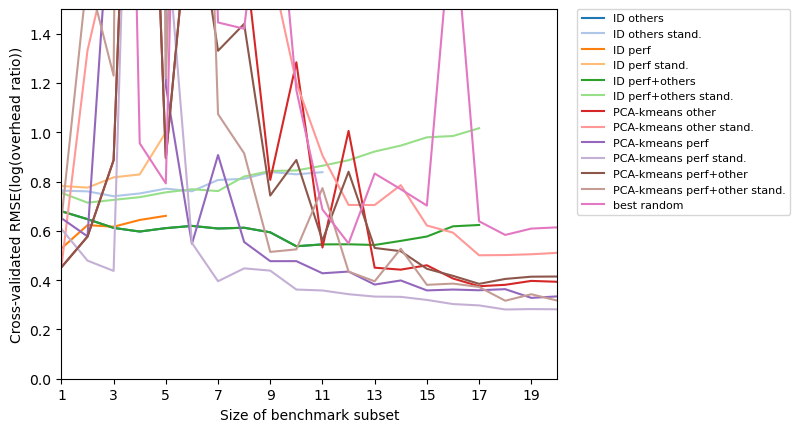

In [507]:
tmpdf = system_predictors_df.sort_values(["predictor", "n_benchmarks"]).set_index("predictor")
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
clip_ymax = 1.5
for i, predictor in enumerate(tmpdf.index.unique()):
    if " feat " in str(predictor):
        continue
    xs = tmpdf.loc[predictor]["n_benchmarks"]
    mid = tmpdf.loc[predictor]["rmse (⇩ = better)"]
    err = tmpdf.loc[predictor]["rmse stddev (⇩ = better)"]
    low = numpy.clip(mid - err / 5, 0, clip_ymax)
    high = numpy.clip(mid + err / 5, 0, clip_ymax)
    #ax.fill_between(xs, low, high, alpha=0.2, color=colors[i])
    ax.plot(xs, mid, color=matplotlib.cm.tab20.colors[i], label=predictor)
ax.set_ylim(0, clip_ymax)
xmax = system_predictors_df["n_benchmarks"].max()
ax.set_xticks(range(1, xmax, 2))
ax.set_xlim(1, xmax)
ax.set_xlabel("Size of benchmark subset")
ax.set_ylabel("Cross-validated RMSE(log(overhead ratio))")
#ax.set_title("Competition for best subsetting algorithm")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, prop={"size": 8})
fig.savefig(output_dir / "subsetting.pdf", bbox_inches="tight")

In [508]:
for whiten in [True, False]:
    for k in range(1, 20):
        predictor = PCAKmeans(k, 0, whiten)
        selected_benchmarks, _ = predictor.select_benchmarks(
            systems_by_benchmarks,
            benchmarks_by_features,
        )
        unselected_benchmarks = [
            benchmark
            for benchmark in range(n_benchmarks)
            if benchmark not in selected_benchmarks
        ]
        predicted = predictor.predict_new_systems(
            systems_by_benchmarks[:, :][:, selected_benchmarks],
        )
        actual = systems_by_benchmarks[:, :][:, unselected_benchmarks]
        rmse = root_mean_squared_error(actual, predicted)
        bmarks = ", ".join(sorted(benchmark_names[i] for i in selected_benchmarks))
        print(f"{predictor!s:20s} {k: 3d}  {numpy.log(rmse):.1f}  {bmarks}")

PCA-kmeans perf+other stand.   1  -0.8  CPU bench SPLASH-3 (cholesky)
PCA-kmeans perf+other stand.   2  -1.1  CPU bench SPLASH-3 (cholesky), IO bench lmbench (fork)
PCA-kmeans perf+other stand.   3  -1.3  CPU bench SPLASH-3 (cholesky), HTTP srv/traffic (simplehttp), IO bench lmbench (fork)
PCA-kmeans perf+other stand.   4  -2.3  CPU bench SPLASH-3 (cholesky), HTTP srv/traffic (nginx), HTTP srv/traffic (simplehttp), IO bench lmbench (fork)
PCA-kmeans perf+other stand.   5  -33.9  HTTP srv/traffic (nginx), HTTP srv/traffic (simplehttp), IO bench lmbench (fork), IO bench lmbench (fs), Un/archive Archive (bzip2)
PCA-kmeans perf+other stand.   6  -34.5  CPU bench SPLASH-3 (fft), HTTP srv/traffic (nginx), HTTP srv/traffic (simplehttp), IO bench lmbench (fork), IO bench lmbench (fs), Un/archive Archive (bzip2)
PCA-kmeans perf+other stand.   7  -35.5  BLAST  (blastn), CPU bench SPLASH-3 (fft), HTTP srv/traffic (nginx), HTTP srv/traffic (simplehttp), IO bench lmbench (fork), IO bench lmbench (f

PCA-kmeans perf stand.


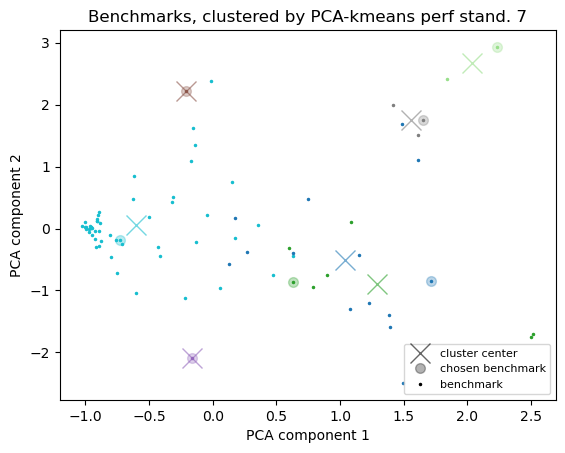

In [509]:
predictor = PCAKmeans(7, 1, True)
predictor.select_benchmarks(systems_by_benchmarks, benchmarks_by_features)
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
print(predictor)
ax.set_title(f"Benchmarks, clustered by {predictor} {predictor.n_benchmarks}")
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
for i in range(len(predictor.rotated_data)):
    ax.plot(
        predictor.rotated_data[i, 0],
        predictor.rotated_data[i, 1], 
        color=colors[predictor.labels[i]],
        marker=".",
        markersize=3,
    )
for cluster_label, benchmark in enumerate(predictor.benchmarks):
    ax.plot(
        predictor.rotated_data[benchmark, 0],
        predictor.rotated_data[benchmark, 1],
        color=(*colors[cluster_label][:3], 0.3),
        marker="o",
        markersize=7,
        markeredgewidth=1,
    )
for cluster_label, cluster_center in enumerate(predictor.kmeans.cluster_centers_):
    ax.plot(
        cluster_center[0],
        cluster_center[1], 
        color=(*colors[cluster_label][:3], 0.6),
        marker="x",
        markersize=15,
        markeredgewidth=1,
    )
ax.legend(
    handles=[
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 0.6), linestyle="", marker="x", markersize=15, markeredgewidth=1, label="cluster center"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 0.3), linestyle="", marker="o", markersize=7, markeredgewidth=1, label="chosen benchmark"),
        matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker=".", markersize=3, label="benchmark"),
    ],
    prop={"size": 8}
    #bbox_to_anchor=(1.04, 0.25),
    #borderaxespad=0,
)
fig.savefig(output_dir / "pca0.pdf", bbox_inches="tight")
xlims = ax.get_xlim()
ylims = ax.get_ylim()

PCA-kmeans perf stand.


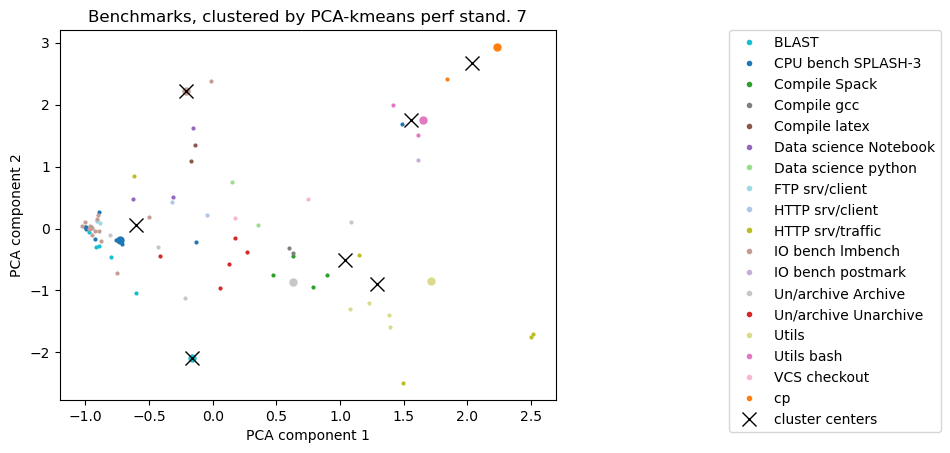

In [510]:
predictor = PCAKmeans(7, 1, True)
predictor.select_benchmarks(systems_by_benchmarks, benchmarks_by_features)
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
print(predictor)
ax.set_title(f"Benchmarks, clustered by {predictor} {predictor.n_benchmarks}")
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
for i in range(len(predictor.rotated_data)):
    ax.plot(
        predictor.rotated_data[i, 0],
        predictor.rotated_data[i, 1], 
        color=colors[workload_kinds.cat.codes[benchmark_names[i]]],
        marker=".",
        markersize=4,
    )
for cluster_label, benchmark in enumerate(predictor.benchmarks):
    ax.plot(
        predictor.rotated_data[benchmark, 0],
        predictor.rotated_data[benchmark, 1],
        color=colors[workload_kinds.cat.codes[benchmark_names[benchmark]]],
        marker="o",
        markersize=5,
        markeredgewidth=1,
    )
for cluster_label, cluster_center in enumerate(predictor.kmeans.cluster_centers_):
    ax.plot(
        cluster_center[0],
        cluster_center[1], 
        color="black",
        marker="x",
        markersize=10,
        markeredgewidth=1,
    )
import scipy.spatial
#vor = scipy.spatial.Voronoi(predictor.kmeans.cluster_centers_[:, :2])
#scipy.spatial.voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.legend(
    handles=[
        *[
            matplotlib.lines.Line2D([0], [0], linestyle="", marker=".", color=color, label=workload_kind)
            for color, workload_kind in zip(colors, workload_kinds.cat.categories)
        ],
        #matplotlib.lines.Line2D([0], [0], linestyle="-", marker="", color="black", label="3-cluster boundaries"),
        #matplotlib.lines.Line2D([0], [0], linestyle="--", marker="", color="black", label="2-cluster boundaries"),
        matplotlib.lines.Line2D([0], [0], linestyle="", marker="x", markersize=10, color="black", label="cluster centers"),
    ],
    bbox_to_anchor=(1.35, 1.0),
    borderaxespad=0,
)
fig.savefig(output_dir / "pca1.pdf", bbox_inches="tight")

# Let's play the new benchmark game

- **Given** the statistical features of a new workload
- **Predict** the workload's log slowdown ratio

In [ ]:
class NewBenchmarkPredictor(abc.ABC):
    @abc.abstractmethod
    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        """
        k: number of benchmarks to select
        systems_by_benchmarks: array where the (i,j)th element is the log of the ith system's slowdown on the jth benchmark
        benchmarks_by_features: array where the (j,m)th element is the mth feature of the jth benchmark
        new_benchmarks_by_features: an array where the (k,m)th element is the mth feature of the kth new benchmark

        returns a tuple containing:
          - an array where the kth element is the log slowdown of the kth *new* benchmark
          - the log-liklihood
        
        """
        pass

    @abc.abstractmethod
    def get_important_features(self) -> list[int]:
        """
        Returns a list of features this predictor feels are "important"

        This is optional, just for interpretability of results.
        """

    @abc.abstractmethod
    def n_parameters(self) -> int:
        """
        Returns the number of parameters used to make this estimation.
        Used to calculate the Akaike Information Criterion.
        """

In [ ]:
import scipy.linalg.interpolative

class Regression(NewBenchmarkPredictor):
    """
    This method simply regresses performance on the set of passed features.

    None means all.

    No linear method should be able to do better in RMSE, but dimensionality reduction may help with AIC.

    Note that the cross-validation score will be overestimated,
    because "variable selection" is not being re-evaluated strictly on the training set.
    """
    def __init__(self, features: list[int] | None) -> None:
        self.pre_features = features

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        self.features = self.pre_features if self.pre_features is not None else list(range(benchmarks_by_features.shape[1]))
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks,
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def get_important_features(self) -> list[int]:
        return self.features

    def __str__(self) -> str:
        return f"linear regression"

In [ ]:
import scipy.linalg.interpolative

class LowRankMatrixFactorization(NewBenchmarkPredictor):
    """
    Like Regression, but use a low-rank compression
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim

    def n_parameters(self) -> int:
        return len(self.a.flatten()) + len(self.b.flatten()) + 1

    def get_important_features(self) -> list[int]:
        coeffs = self.a @ self.b
        feature_importance = numpy.fabs(coeffs.sum(axis=0))
        normed_feature_importance = feature_importance / feature_importance.sum()
        return [
            feature
            for feature, importance in enumerate(normed_feature_importance)
            if importance > 0.2
        ]

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        tmp = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features.T)
        u, s, vh = numpy.linalg.svd(tmp, full_matrices=False)
        self.a = (u[:, :self.dim] * s[:self.dim])
        self.b = vh[:self.dim, :]
        log_likelihood = naive_log_likelihood(
            self.a @ self.b @ benchmarks_by_features.T,
            systems_by_benchmarks,
        )
        return self.a @ self.b @ new_benchmarks_by_features.T, log_likelihood

    def __str__(self) -> str:
        return f"low-rank factorization"

In [ ]:
import scipy.linalg.interpolative

class GreedySubsetMatrixFactorization(NewBenchmarkPredictor):
    """
    This method tries to select only dim features.

    This is subtly different from "compressing to a matrix of rank dim".

    Using only dim features, means the other coefficients **have to be** zero.

    It's greedy because it picks the best feature, and adds next best given the current set, etc.
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def get_important_features(self) -> list[int]:
        return self.features

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        def test_goodness(features: list[int]) -> numpy.float64:
            systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, features].T)
            return numpy.sum((systems_by_features @ benchmarks_by_features[:, features].T - systems_by_benchmarks)**2)
        selected_features = []
        while len(selected_features) < self.dim:
            unselected_features = [
                feature
                for feature in range(benchmarks_by_features.shape[1])
                if feature not in selected_features
            ]
            selected_features = min([
                selected_features + [candidate_feature]
                for candidate_feature in unselected_features
            ], key=test_goodness)
        self.features = selected_features
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def __str__(self) -> str:
        return f"greedy feature selection"

In [310]:
import random

class BestOfNMatrixFactorization(NewBenchmarkPredictor):
    """
    This method tries `iters` feature subsets, selecting the best.
    """
    def __init__(self, dim: int, iters: int) -> None:
        self.dim = dim
        self.iters = iters

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def get_important_features(self) -> list[int]:
        return self.features

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        def test_goodness(features: list[int]) -> numpy.float64:
            systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, features].T)
            return numpy.sum((systems_by_features @ benchmarks_by_features[:, features].T - systems_by_benchmarks)**2)
        rng = random.Random(0)
        best_feature_set = None
        best_feature_score = None
        features = list(range(benchmarks_by_features.shape[1]))
        for _ in range(self.iters):
            feature_set = rng.sample(features, self.dim)
            score = test_goodness(feature_set)
            if best_feature_score is None or score < best_feature_score:
                best_feature_score = score
                best_feature_set = feature_set
        self.features = best_feature_set
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def __str__(self) -> str:
        return f"random-best"

In [305]:
def test_benchmark_predictors(
    predictors: list[NewBenchmarkPredictor],
) -> None:
    benchmarks = list(range(n_benchmarks))
    test_size = 0.1
    cv_splitter = sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=test_size, random_state=0)
    predictor_records = []
    for predictor in predictors:
        predictor_rmse = list[int]()
        important_features = collections.Counter()
        for train_benchmarks, test_benchmarks in cv_splitter.split(benchmarks):
            predicted, _ = predictor.predict_new_benchmark(
                systems_by_benchmarks[:, train_benchmarks],
                benchmarks_by_features[train_benchmarks, :],
                benchmarks_by_features[test_benchmarks, :],
            )
            for important_feature in predictor.get_important_features():
                important_features[important_feature] += 1
            actual = systems_by_benchmarks[:, test_benchmarks]
            predictor_rmse.append(root_mean_squared_error(actual, predicted))
        _, log_likelihood = predictor.predict_new_benchmark(systems_by_benchmarks, benchmarks_by_features, benchmarks_by_features)
        n_datapoints = len(systems_by_benchmarks.flatten()) + len(benchmarks_by_features.flatten())
        params = predictor.n_parameters()
        predictor_aicc = aicc(params, log_likelihood, n_datapoints)
        important_feature_names = {feature_names[feature]: count for feature, count in important_features.most_common()}
        predictor_records.append({
            "predictor": str(predictor),
            "rmse": numpy.mean(predictor_rmse),
            "rmse stddev": numpy.std(predictor_rmse),
            "log_likelihood": log_likelihood,
            "params": params - 1,
            "aicc": predictor_aicc,
            "features selected": important_feature_names,
        })
        print(
            f"{numpy.mean(predictor_rmse): 5.2f}",
            f"{numpy.std(predictor_rmse): 5.2f}",
            f"{log_likelihood: 7.1f}",
            f"{params: 4d}",
            f"{predictor_aicc: 9.2f}",
            predictor,
            important_feature_names,
        )
    return pandas.DataFrame.from_records(predictor_records)

benchmark_predictors = test_benchmark_predictors([
    Regression(None),
    #Regression([feature_names.index("cputime_per_sec")]),
    #Regression([feature_names.index("chmod_syscalls_per_sec")]),
    *[
        LowRankMatrixFactorization(i)
        for i in range(1, n_features + 1)
    ],
    *[
        GreedySubsetMatrixFactorization(i)
        for i in range(1, n_features + 1)
    ],
    *[
        BestOfNMatrixFactorization(i, 1000)
        for i in range(1, n_features + 1)
    ]
])

 1.87  2.17   332.5   81   -503.08 linear regression {'cputime_per_sec': 10, 'socket_syscalls_per_sec': 10, 'metadata_syscalls_per_sec': 10, 'chmod_syscalls_per_sec': 10, 'dir_syscalls_per_sec': 10, 'file_syscalls_per_sec': 10, 'ftruncate_syscalls_per_sec': 10, 'exec_syscalls_per_sec': 10, 'clone_syscalls_per_sec': 10, 'exits_syscalls_per_sec': 10, 'dups_syscalls_per_sec': 10, 'close_syscalls_per_sec': 10, 'pipe_syscalls_per_sec': 10, 'chdir_syscalls_per_sec': 10, 'other_syscalls_per_sec': 10, 'constant_frac': 10}
 1.88  1.78   -46.5   22    136.92 low-rank factorization {'ftruncate_syscalls_per_sec': 10, 'cputime_per_sec': 1}
 1.85  2.09   345.9   43   -605.81 low-rank factorization {'ftruncate_syscalls_per_sec': 9, 'cputime_per_sec': 6}
 1.85  2.14   353.1   64   -578.22 low-rank factorization {'ftruncate_syscalls_per_sec': 9, 'cputime_per_sec': 6}
 1.87  2.17   332.5   85   -495.08 low-rank factorization {'ftruncate_syscalls_per_sec': 9, 'cputime_per_sec': 6}
 1.87  2.17   332.5  10

In [306]:
benchmark_predictors.sort_values("rmse")

,predictor,rmse,rmse stddev,log_likelihood,params,aicc,features selected
36,random-best,0.909412,1.391378,284.354166,20,-526.708331,"{'cputime_per_sec': 10, 'constant_frac': 10, '..."
20,greedy feature selection,0.909412,1.391378,284.354166,20,-526.708331,"{'constant_frac': 10, 'cputime_per_sec': 10, '..."
19,greedy feature selection,0.956394,1.369187,263.983829,15,-495.967659,"{'constant_frac': 10, 'cputime_per_sec': 10, '..."
35,random-best,1.047523,1.340603,258.336974,15,-484.673948,"{'constant_frac': 10, 'cputime_per_sec': 9, 'c..."
34,random-best,1.132690,1.591698,108.537309,10,-195.074618,"{'constant_frac': 10, 'metadata_syscalls_per_s..."
18,greedy feature selection,1.132690,1.591698,108.537309,10,-195.074618,"{'constant_frac': 10, 'metadata_syscalls_per_s..."
21,greedy feature selection,1.233413,2.342830,295.698280,25,-539.396560,"{'constant_frac': 10, 'cputime_per_sec': 10, '..."
17,greedy feature selection,1.255966,1.672496,-23.619408,5,59.238815,"{'metadata_syscalls_per_sec': 9, 'file_syscall..."
33,random-best,1.255966,1.672496,-23.619408,5,59.238815,"{'metadata_syscalls_per_sec': 9, 'file_syscall..."
37,random-best,1.280848,1.621271,279.044813,25,-506.089627,"{'constant_frac': 10, 'cputime_per_sec': 10, '..."


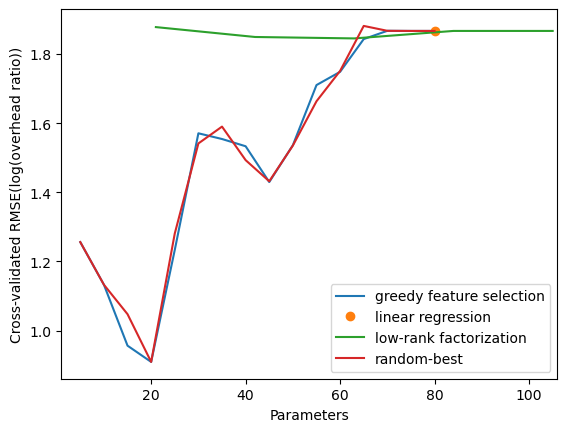

In [307]:
tmpdf = benchmark_predictors.sort_values(["predictor", "params"]).set_index("predictor")
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
clip_ymax = 2
for i, predictor in enumerate(tmpdf.index.unique()):
    if " feat " in str(predictor):
        continue
    xs = tmpdf.loc[predictor]["params"]
    mid = tmpdf.loc[predictor]["rmse"]
    err = tmpdf.loc[predictor]["rmse stddev"]
    low = numpy.clip(mid - err / 5, 0, clip_ymax)
    high = numpy.clip(mid + err / 5, 0, clip_ymax)
    #ax.fill_between(xs, low, high, alpha=0.2, color=colors[i])
    ax.plot(
        xs,
        mid,
        color=matplotlib.cm.tab10.colors[i],
        label=predictor,
        #alpha=0.5,
        marker="o" if predictor == "linear regression" else "",
        linestyle="" if predictor == "linear regression" else "-",
    )
#ax.set_ylim(0, clip_ymax)
xmax = df["params (⇩ = better)"].max()
#ax.set_xticks(range(0, xmax, 2))
ax.set_xlim(1, xmax)
ax.set_xlabel("Parameters")
ax.set_ylabel("Cross-validated RMSE(log(overhead ratio))")
#ax.set_title("Competition for best subsetting algorithm")
ax.legend(
    #bbox_to_anchor=(1.04, 1), borderaxespad=0
)
fig.savefig(output_dir / "predictive-performance.pdf", bbox_inches="tight")

In [334]:
pred = GreedySubsetMatrixFactorization(4)
_, _ = pred.predict_new_benchmark(systems_by_benchmarks, benchmarks_by_features, benchmarks_by_features)
print(
    pandas.DataFrame(
        index=[collector_names[i] for i in range(n_systems)],
        columns=[feature_names[i] for i in pred.get_important_features()],
        data=pred.systems_by_features,
    )
    .map("{:.6f}".format)
    .to_latex()
    .replace("_", " ")
)

\begin{tabular}{lllll}
\toprule
 & metadata syscalls per sec & constant frac & cputime per sec & exec syscalls per sec \\
\midrule
fsatrace & 0.000003 & -0.001236 & -0.024958 & 0.000064 \\
noprov & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
reprozip & 0.000043 & -0.027311 & 0.266969 & 0.000438 \\
rr & 0.000021 & -0.011208 & 0.404307 & 0.000878 \\
strace & 0.000029 & -0.002243 & 0.229129 & 0.000312 \\
\bottomrule
\end{tabular}



In [328]:
pred.systems_by_features

array([[ 3.38106888e-06, -1.23635578e-03, -2.49584806e-02,
         6.42043522e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.34258842e-05, -2.73112359e-02,  2.66968529e-01,
         4.38194774e-04],
       [ 2.05672706e-05, -1.12080241e-02,  4.04307037e-01,
         8.78057643e-04],
       [ 2.92724067e-05, -2.24259503e-03,  2.29129035e-01,
         3.11855241e-04]])

In [308]:
n_features

16

In [301]:
n_benchmarks

76

# What about new-system-and-benchmark?

- **Given** integer N and workloads x benchmark matrix
- **Select** N workloads
- **Given** new system's log slowdown ratio on N selected workloads and features of new workload
- **Predict** new system's log slowdown ratio on new workload

Not implemented yet. Maybe won't be ever. Who would be picking a new system and new benchmark at the same time?

In [ ]:
# Ignore this class

class NewSystemAndBenchmarkProblem(abc.ABC):

    @abc.abstractmethod
    def select_benchmarks(
        self,
        k: int,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        """
        k: number of benchmarks to select
        systems_by_benchmarks: array where the (i,j)th element is the log of the ith system's slowdown on the jth benchmark
        benchmarks_by_features: array where the (j,m)th element is the mth feature of the jth benchmark


        returns a tuple containing:
          - k benchmarks to select
          - the log-liklihood
        
        Liklihood is the probability of observing this data given the parameters you inferred
        Used to compute the Akaike Information Criterion.
        Return numpy.NaN if you just don't care.     
        """
        pass

    @abc.abstractmethod
    def n_parameters(self) -> int:
        """
        Returns the number of parameters used to make this estimation.
        Used to calculate the Akaike Information Criterion.
        """

    @abc.abstractmethod
    def predict_new_system_on_new_benchmarks(
        self,
        new_system_by_selected_benchmarks: numpy.typing.NDArray,
        selected_benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        """
        new_system_by_selected_benchmarks: array where the qth element is the log of the new system's slowdown on the qth selected benchmark
        selected_benchmarks_by_features: array where the (q,m)th element is the mth feature of the qth selected benchmark
        new_benchmarks_by_features: array where the (p,m)th element is the mth feature of the pth new benchmark

        returns an array where the pth element is the log slowdown of the new system on the pth new benchmark
        """
        pass